<a href="https://colab.research.google.com/github/Jillian-T/DPGM/blob/main/HGP-EPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import torch
import matplotlib.pyplot as plt
import scipy.io as scio

from tqdm.auto import tqdm
from dataclasses import dataclass
from torch.distributions import Gamma, Multinomial

c:\Users\j1487\miniconda3\envs\EPM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


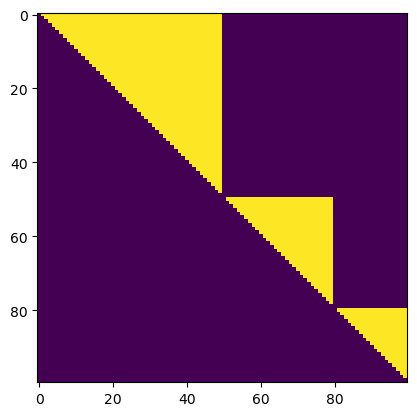

In [2]:
syn_data = torch.zeros(100, 100)

syn_data[:50, :50] = torch.ones(50, 50)
syn_data[50:80, 50:80] = torch.ones(30, 30)
syn_data[80:, 80:] = torch.ones(20, 20)

syn_data = torch.triu(syn_data, diagonal=1)
plt.imshow(syn_data)

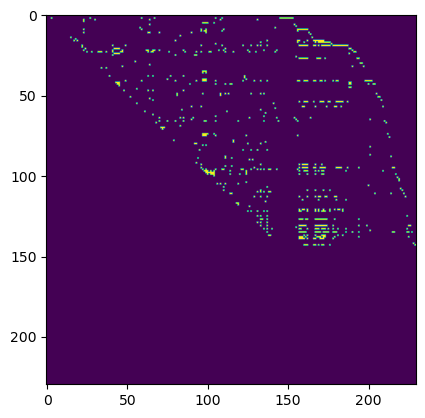

In [3]:
protein_data = scio.loadmat('./data/Protein230.mat')
protein_data = torch.from_numpy(protein_data['B'].todense())

plt.imshow(protein_data)

In [4]:
@dataclass
class ExperimentConfig:
    N: int
    K: int
    train_ratio: float
    burnin: int
    collection: int
    binary: bool
    eps: float = 1e-32

syn_config = ExperimentConfig(100, 100, 1., 1500, 1500, True)
protein_config = ExperimentConfig(230, 100, 1., 1500, 1500, True)

In [5]:
def Po_plus(rate):
    r1 = rate[rate>=1]
    r2 = rate[rate<1]
    m = torch.zeros_like(rate)
    m1 = torch.zeros_like(r1)
    m2 = torch.zeros_like(r2)

    while True:
        dex = (m1 == 0).nonzero(as_tuple=True)
        if dex[0].numel() == 0:
            break
        else:
            r_dex = r1[dex]
            temp = torch.poisson(r_dex)
            idex = temp > 0
            m1[dex] = torch.where(idex, temp, m1[dex])
    m[rate>=1] = m1

    while True:
        dex = (m2 == 0).nonzero(as_tuple=True)
        if dex[0].numel() == 0:
            break
        else:
            r_dex = r2[dex]
            temp = 1 + torch.poisson(r_dex)
            idex = torch.rand_like(temp) < (1 / temp)
            m2[dex] = torch.where(idex, temp, m2[dex])
    m[rate<1] = m2

    return m

def multrnd_histc(n, p):
    edges = torch.cumsum(p, dim=0)
    edges = torch.nn.functional.pad(edges, pad=[1, 0], value=0)
    
    r = torch.histogram(
        torch.rand(n) * edges[-1],
        edges
    ).hist
    return r

def CRT(n, a):
    max_x = torch.max(n)
    rates = torch.arange(0, max_x).expand(*n.size(), -1)
    rates = a.unsqueeze(-1) / (a.unsqueeze(-1) + rates)
    bers = torch.bernoulli(rates)
    mask = (torch.arange(0, max_x).expand(*n.size(), -1) < n.unsqueeze(-1)).to(torch.int)
    bers = bers * mask
    return torch.sum(bers, dim=-1)

In [6]:
class HGP_EPM:
    def __init__(self, config: ExperimentConfig):
        self.N = config.N
        self.K = config.K
        self.binary = config.binary
        self.eps = config.eps

        self.c_0 = 1.
        self.c_i = torch.ones(self.N)
        self.a_i = torch.ones(self.N) / self.N
        self.e_0 = 1.
        self.f_0 = 0.01
        self.xi = 1.
        self.beta = 1.
        self.gamma_0 = 1.

        self.r = torch.ones(self.K) / self.K
        self.phi = Gamma(torch.ones(self.N, self.K), torch.ones(1)).sample()

        lam_kk = self.r.view(-1, 1) @ self.r.view(1, -1)
        lam_kk = torch.triu(lam_kk, 1) + torch.triu(lam_kk, 1).T
        lam_kk[torch.eye(self.K, self.K, dtype=torch.bool)] = self.r * self.xi
        self.lam_kk = lam_kk
    
    def gammaAccept(self, Q_gamma):
        prob = Gamma(Q_gamma/self.K, self.c_0).log_prob(self.r).sum() + Gamma(1., 1.).log_prob(torch.FloatTensor([Q_gamma]))
        prob -= Gamma(self.gamma_0/self.K, self.c_0).log_prob(self.r).sum() + Gamma(1., 1.).log_prob(torch.FloatTensor([self.gamma_0]))
        prob = torch.exp(prob) * (self.gamma_0 / Q_gamma)
        return prob.item() > 1
        
    def do_inference(self, m_idx, n_idx, X):
        diag_mask = torch.eye(self.K, self.K, dtype=torch.bool)
        triu_mask = torch.triu(torch.ones(self.K, self.K, dtype=torch.bool), diagonal=1)
        
        if self.binary:
            rate = torch.sum((self.phi[m_idx] @ self.lam_kk) * self.phi[n_idx],dim=-1)   # size=(num)
            X = Po_plus(rate)
        
        # Sample latents then x_dot_kk_dot and x_mnk_ddot
        x_dot_kk_dot = torch.zeros(self.K, self.K)
        x_ik_ddot = torch.zeros(self.N, self.K)
        for i, j, x in zip(m_idx, n_idx, X):
            pmf = (self.phi[i].view(-1, 1) @ self.phi[j].view(1, -1)) * self.lam_kk     # size=(K, K)
            x_ikkj = Multinomial(x.to(torch.int).item(), pmf.flatten()).sample().reshape(self.K, self.K)
            # x_ikkj = multrnd_histc(x.to(torch.int), pmf.flatten()).reshape(self.K, self.K)
            x_ik_ddot[i] += x_ikkj.sum(dim=-1)
            x_ik_ddot[j] += x_ikkj.sum(dim=0)
            x_dot_kk_dot += x_ikkj + x_ikkj.T
        x_dot_kk_dot[diag_mask] *= 0.5
        
        # Sample a_i
        l_ik = CRT(x_ik_ddot, self.a_i.unsqueeze(-1))   # size = (N, K)
        phi_lam = self.phi @ self.lam_kk                # size = (N, K)
        omega_ik = phi_lam.sum(dim=0, keepdim=True) - phi_lam         # size = (N, K)
        p_prime_ik = omega_ik / (self.c_i.unsqueeze(-1) + omega_ik)   # size = (N, K)
        ai_alpha = self.e_0 + l_ik.sum(dim=-1)
        ai_beta = self.f_0 - torch.log((1-p_prime_ik).clamp_min(self.eps)).sum(dim=-1)
        self.a_i = Gamma(ai_alpha, ai_beta).sample()
        
        # Sample phi
        phi_alpha = self.a_i.unsqueeze(-1) + x_ik_ddot
        for i in torch.randperm(self.N):
            _phi_lam = self.phi @ self.lam_kk
            _omege_ik = _phi_lam.sum(dim=0, keepdim=True) - _phi_lam
            _beta = self.c_i[i] + _omege_ik[i]
            self.phi[i] = Gamma(phi_alpha[i], _beta).sample()
        
        # Sample c_i
        c_i_alpha = 1 + self.K * self.a_i
        c_i_beta = 1 + self.phi.sum(dim=-1)
        self.c_i = Gamma(c_i_alpha, c_i_beta).sample()
        
        # Sample r
        theta_kk = self.phi.T @ (self.phi.sum(dim=0, keepdim=True) - self.phi)          # size = (K, K)
        theta_kk[diag_mask] *= 0.5
        one_minus_p_tilde_kk = torch.clamp_min(self.beta / (self.beta + theta_kk), self.eps)      # size = (K, K)
        l_kk = torch.zeros(self.K, self.K)
        r_kk_xi = torch.zeros(self.K, self.K)
        for i in torch.randperm(self.K):
            r_xi = self.r
            r_xi[i] = self.xi
            l_kk[i] = CRT(x_dot_kk_dot[i], (self.r[i] * r_xi).clamp_min(self.eps))    # size = (K,)
            r_alpha = self.gamma_0 / self.K + l_kk[i].sum()
            r_beta = self.c_0 - torch.sum(r_xi * torch.log(one_minus_p_tilde_kk))
            self.r[i] = Gamma(r_alpha, r_beta).sample()
            r_kk_xi[i] = self.r
        
        # Sample xi
        xi_alpha = self.e_0 + l_kk[diag_mask].sum()
        xi_beta = self.f_0 - torch.sum(self.r * torch.log(one_minus_p_tilde_kk[diag_mask]))
        self.xi = Gamma(xi_alpha, xi_beta).sample().item()
        r_kk_xi[diag_mask] = self.xi
        
        # Sample gamma0
        p_ttilde_k = torch.sum(r_kk_xi * torch.log(one_minus_p_tilde_kk), dim=-1)
        one_minus_p_ttilde_k = torch.clamp_min(self.c_0 / (self.c_0 - p_ttilde_k), self.eps)
        l_tilde_k = CRT(l_kk.sum(dim=-1), self.gamma_0 / self.K * torch.ones(self.K))
        gam_alpha = self.e_0 + l_tilde_k.sum()
        gam_beta = 1 - 1 / self.K * torch.log(one_minus_p_ttilde_k).sum()
        Q_gamma0 = Gamma(gam_alpha, gam_beta).sample().item()
        if self.gammaAccept(Q_gamma0):
            self.gamma_0 = Q_gamma0
        
        # Sample c_0
        c0_alpha = 1 + self.gamma_0
        c0_beta = 1 + self.r.sum()
        self.c_0 = Gamma(c0_alpha, c0_beta).sample().item()
        
        # Sample xi
        l_kk = CRT(x_dot_kk_dot[diag_mask], self.xi * self.r).sum(dim=0)
        xi_alpha = self.e_0 + l_kk.sum()
        xi_beta = self.f_0 - torch.sum(self.r * torch.log((1-p_prime_ik).clamp_min(self.eps)))
        self.xi = Gamma(xi_alpha, xi_beta).sample().item()
        
        # Sample lam_kk
        lam_kk_alpha = r_kk_xi + x_dot_kk_dot
        lam_kk_beta = self.beta + theta_kk
        self.lam_kk = Gamma(lam_kk_alpha, lam_kk_beta).sample()
        
        # Sample beta
        beta_a = self.e_0 + r_kk_xi[diag_mask | triu_mask].sum()
        beta_b = self.f_0 + self.lam_kk[diag_mask | triu_mask].sum()
        self.beta = Gamma(beta_a, beta_b).sample().item()
        
        return x_ik_ddot

## Model Synthetic data

100%|██████████| 3000/3000 [1:45:50<00:00,  2.12s/it, K_plus=100, K_hard=30, gamma0=60.7]


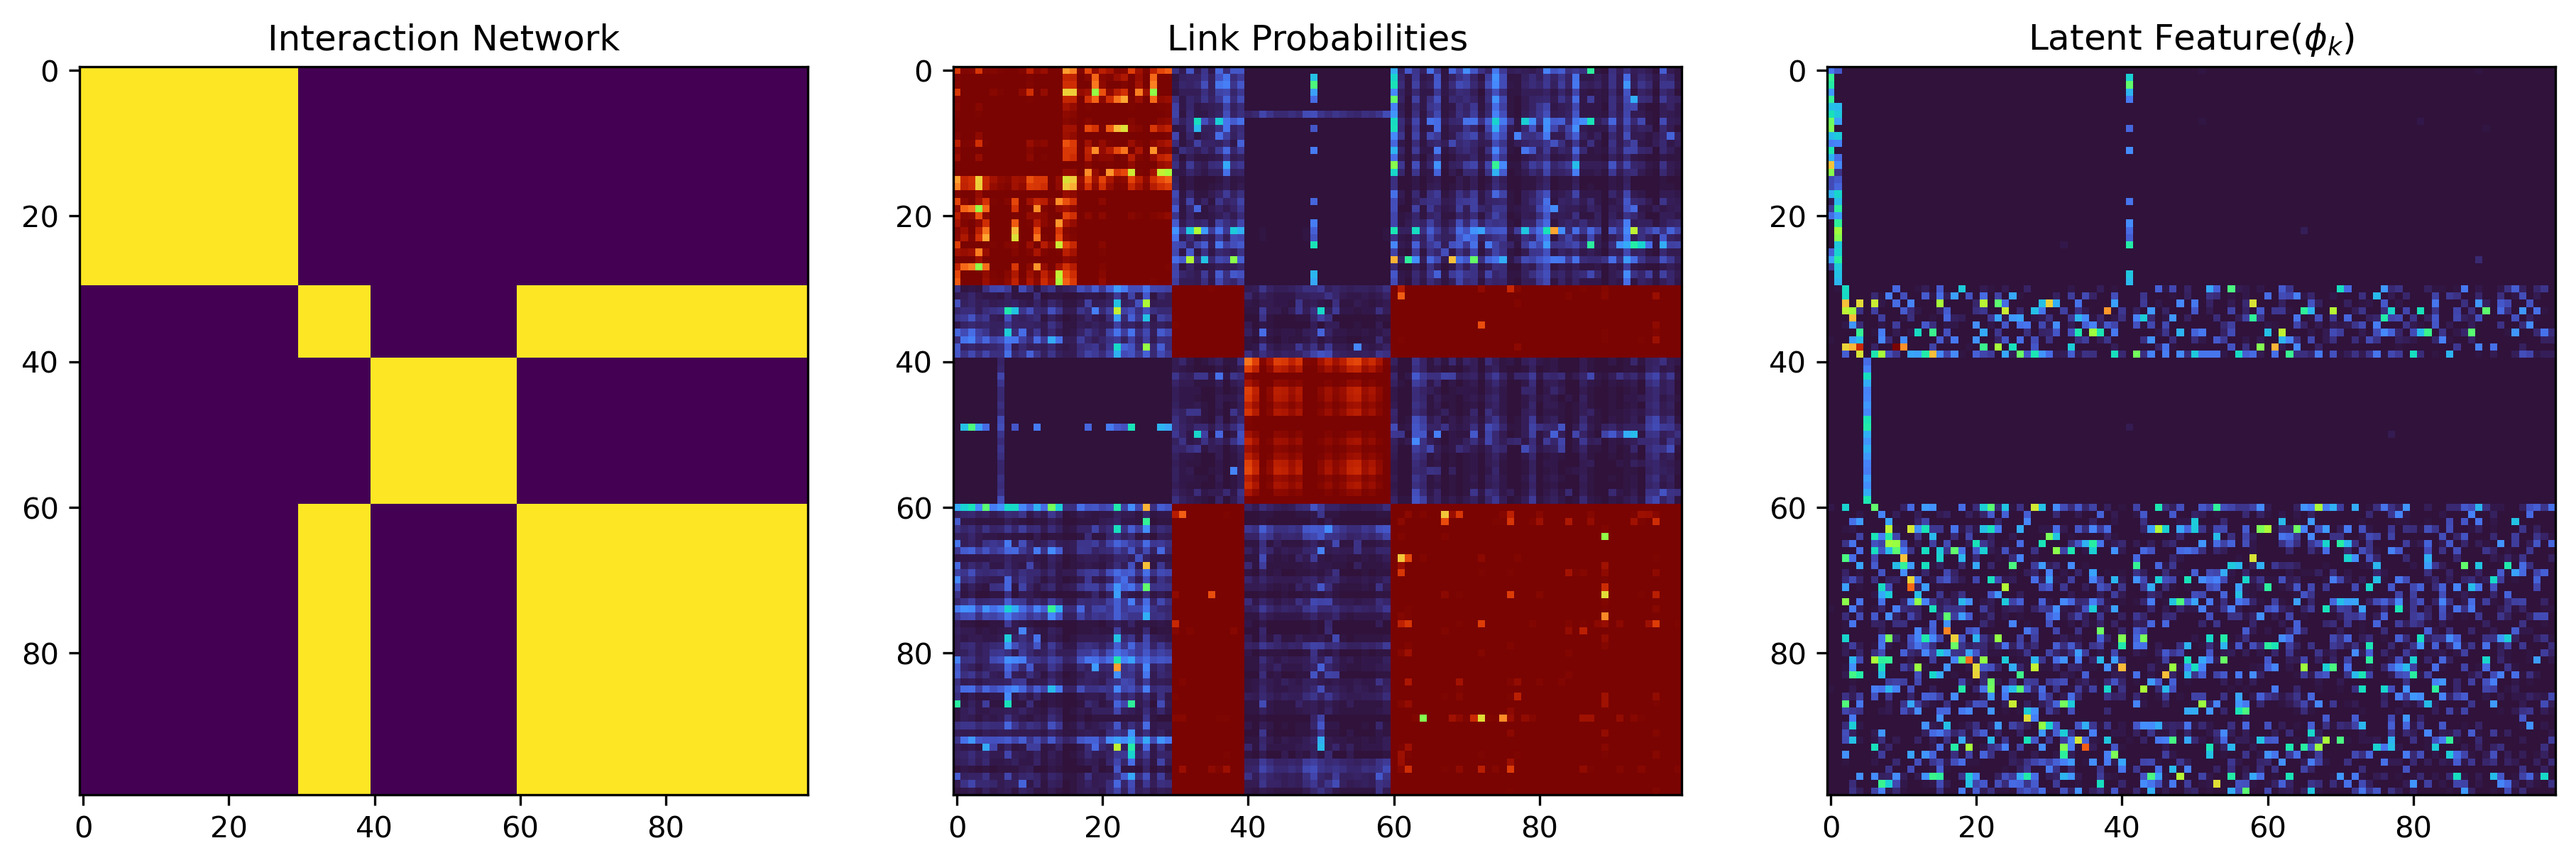

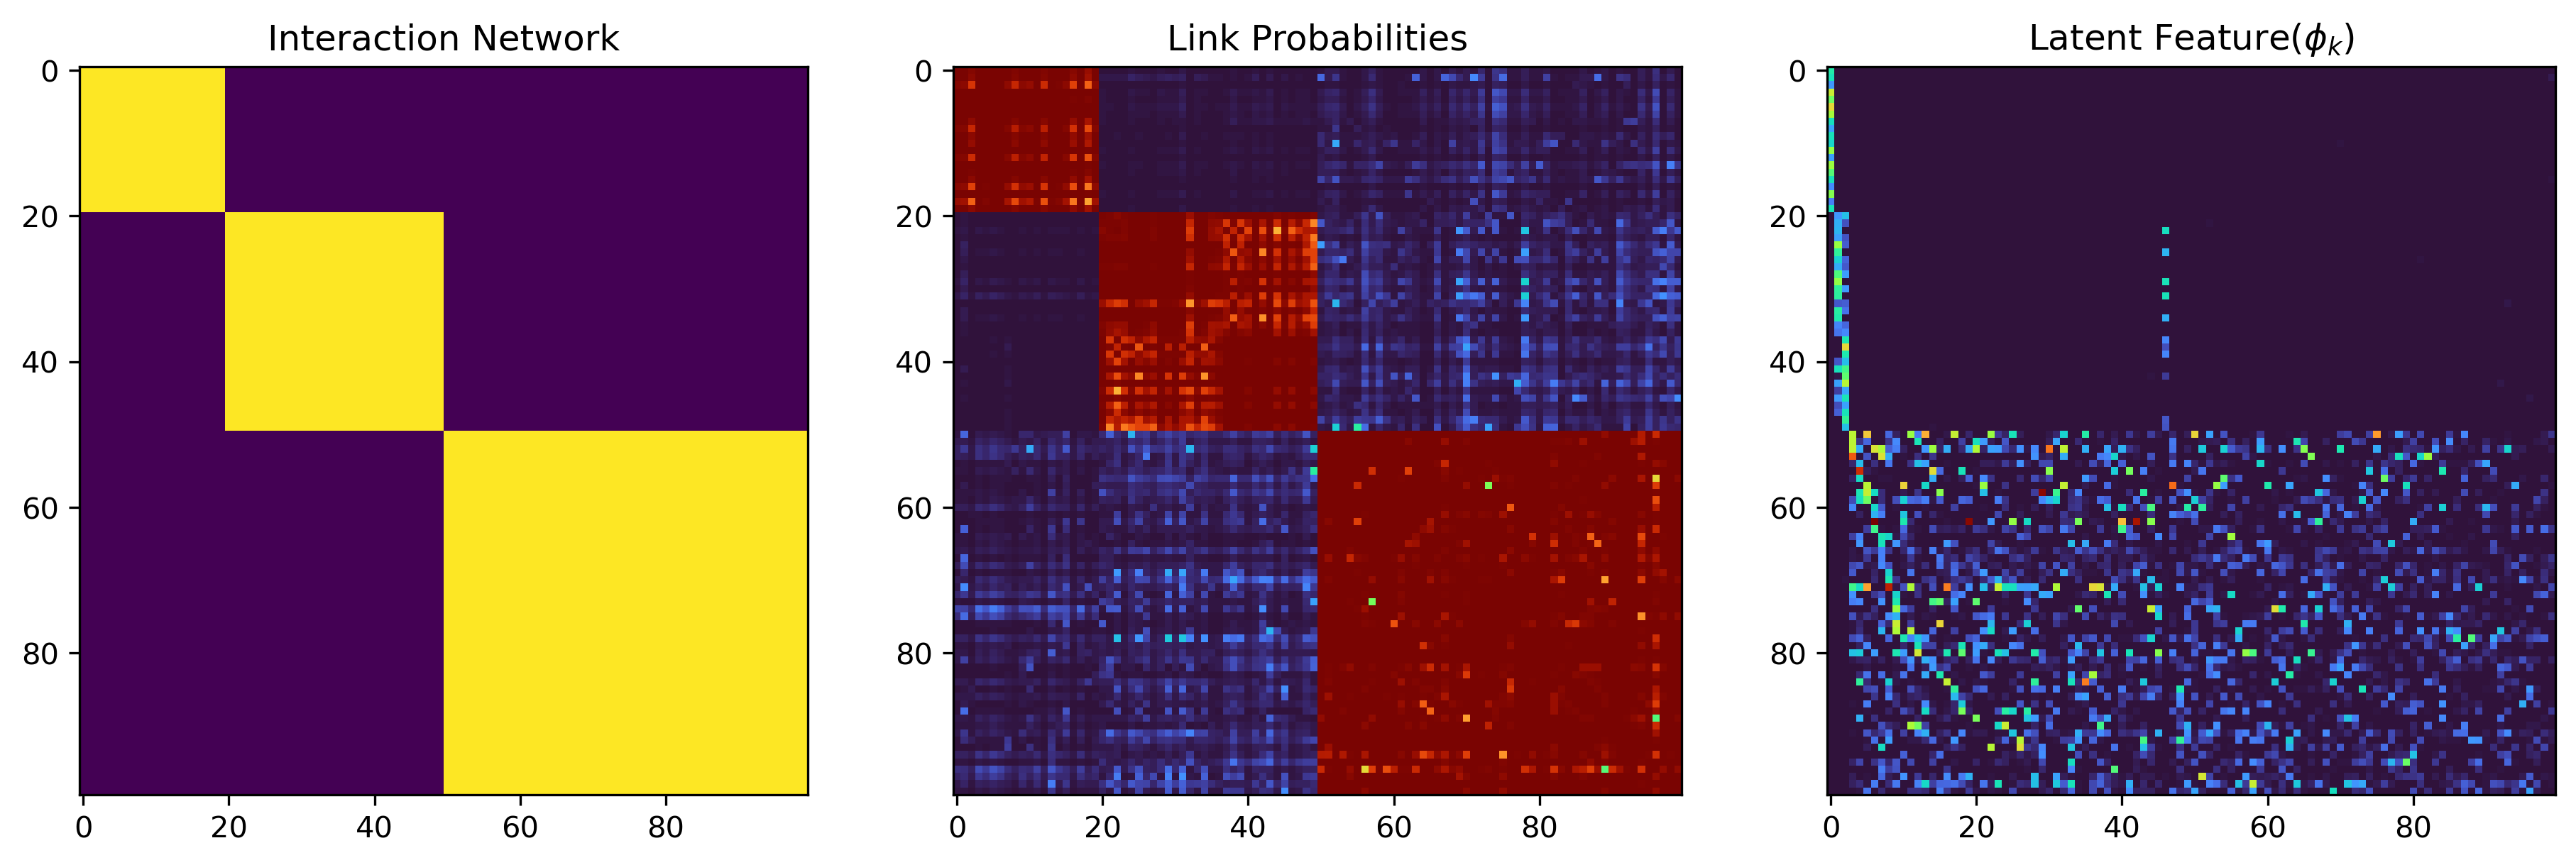

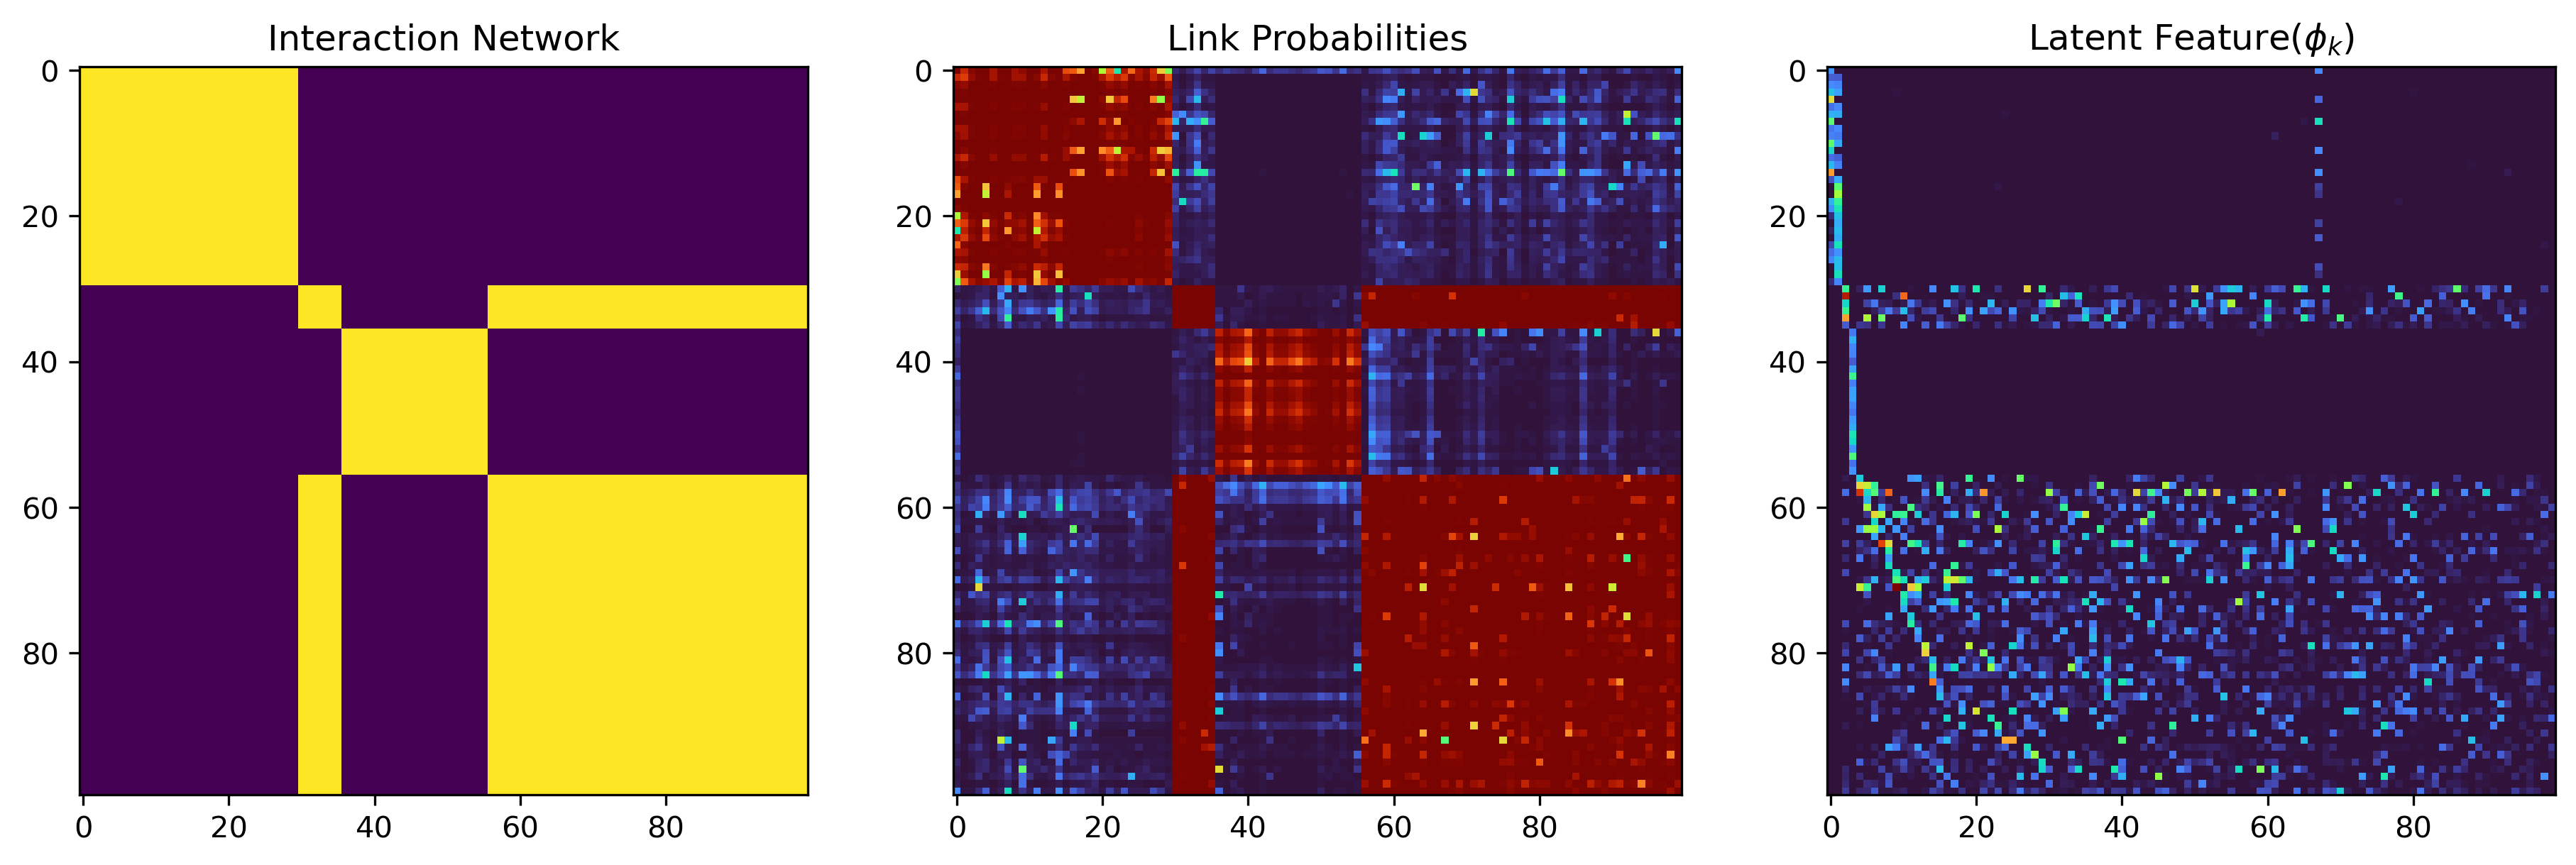

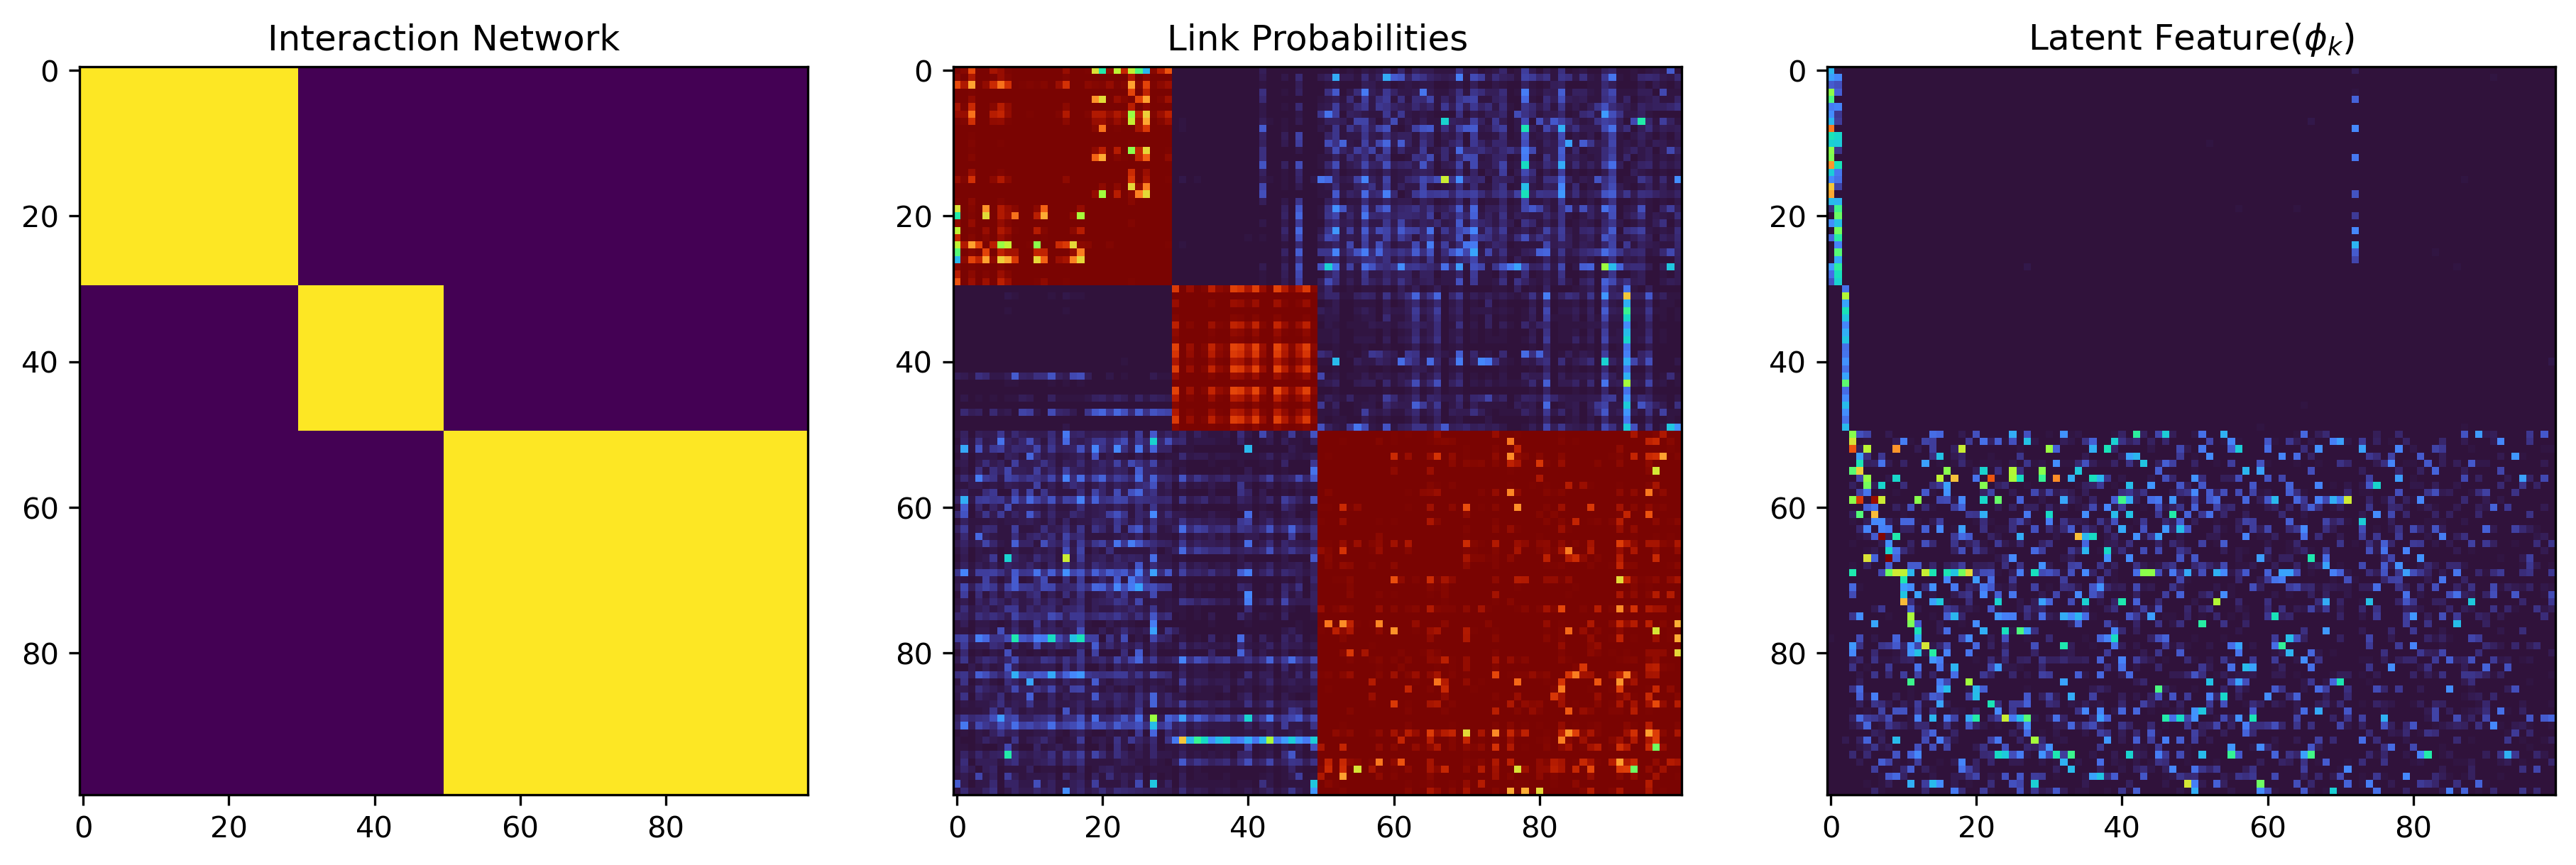

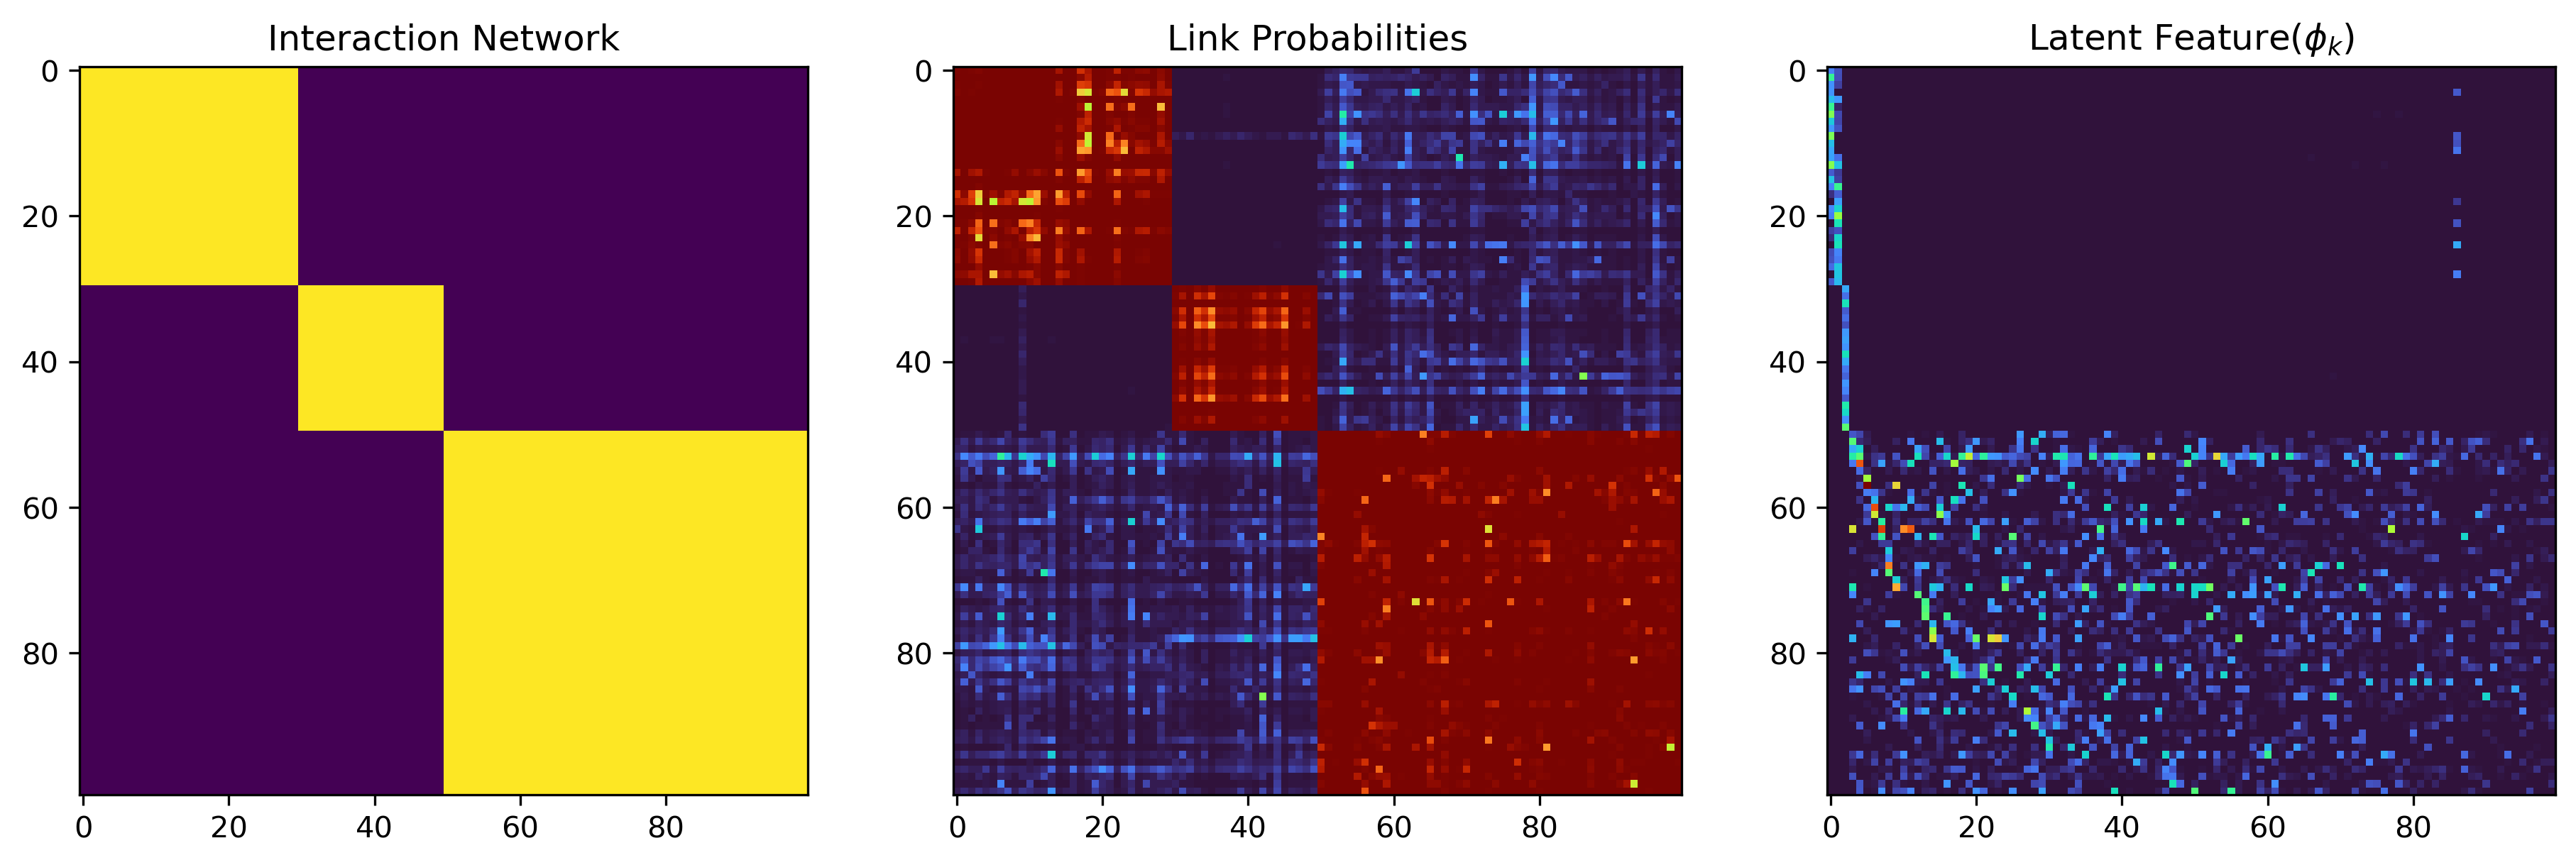

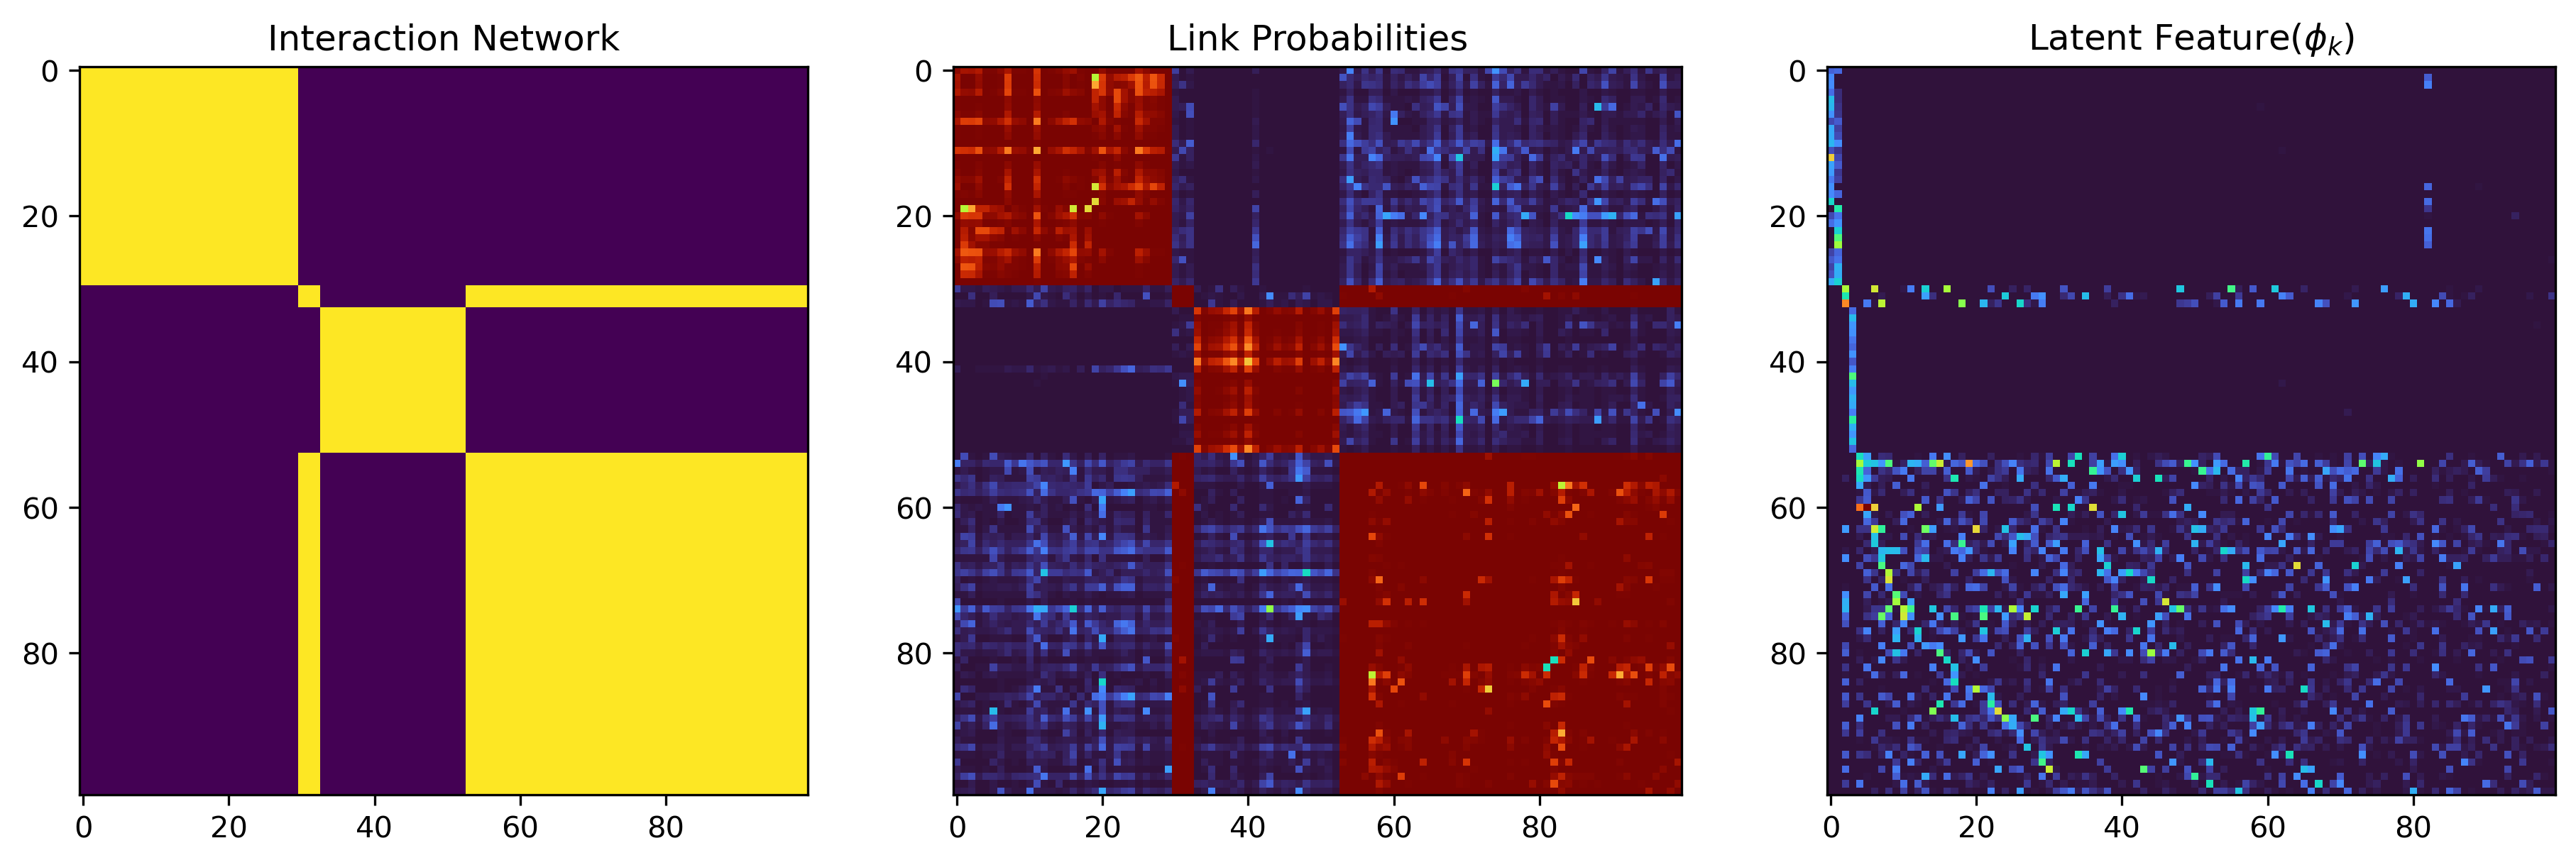

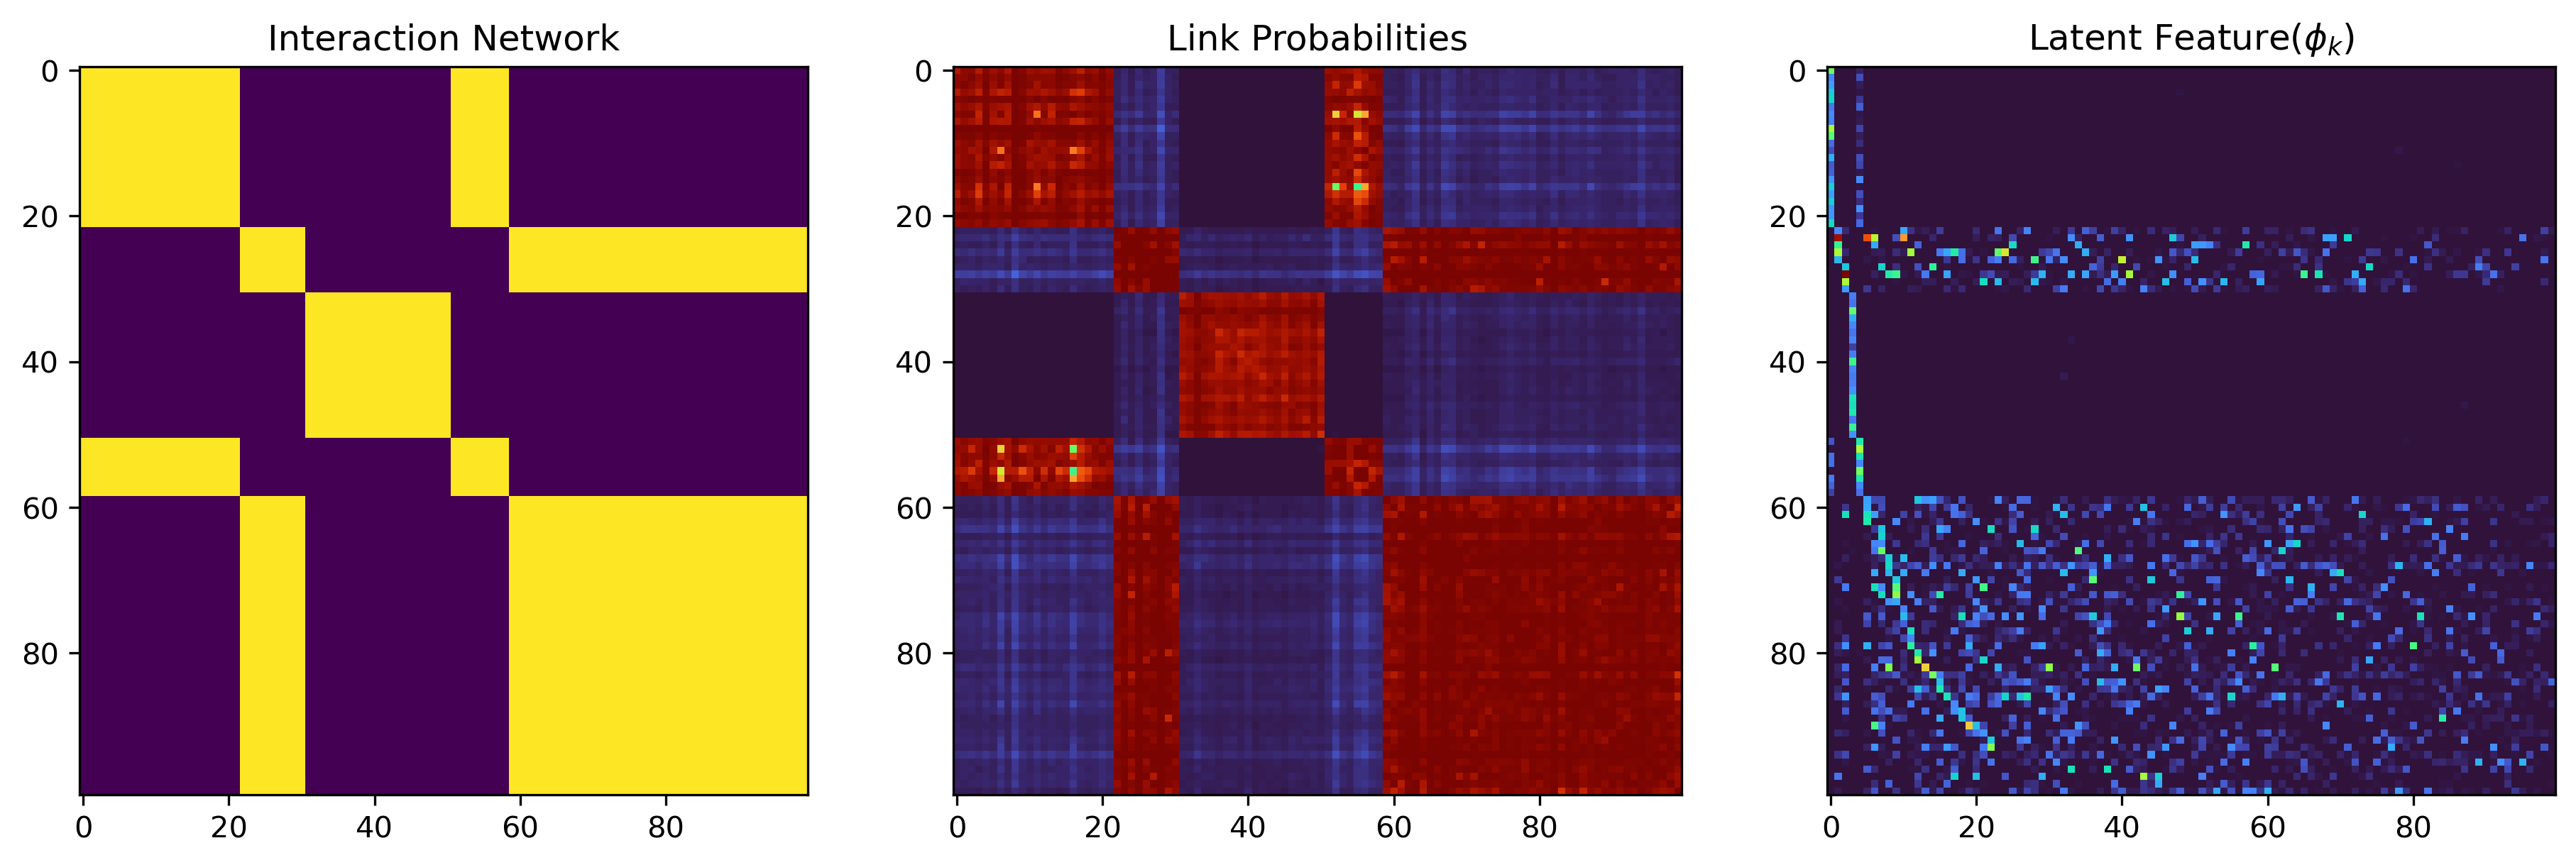

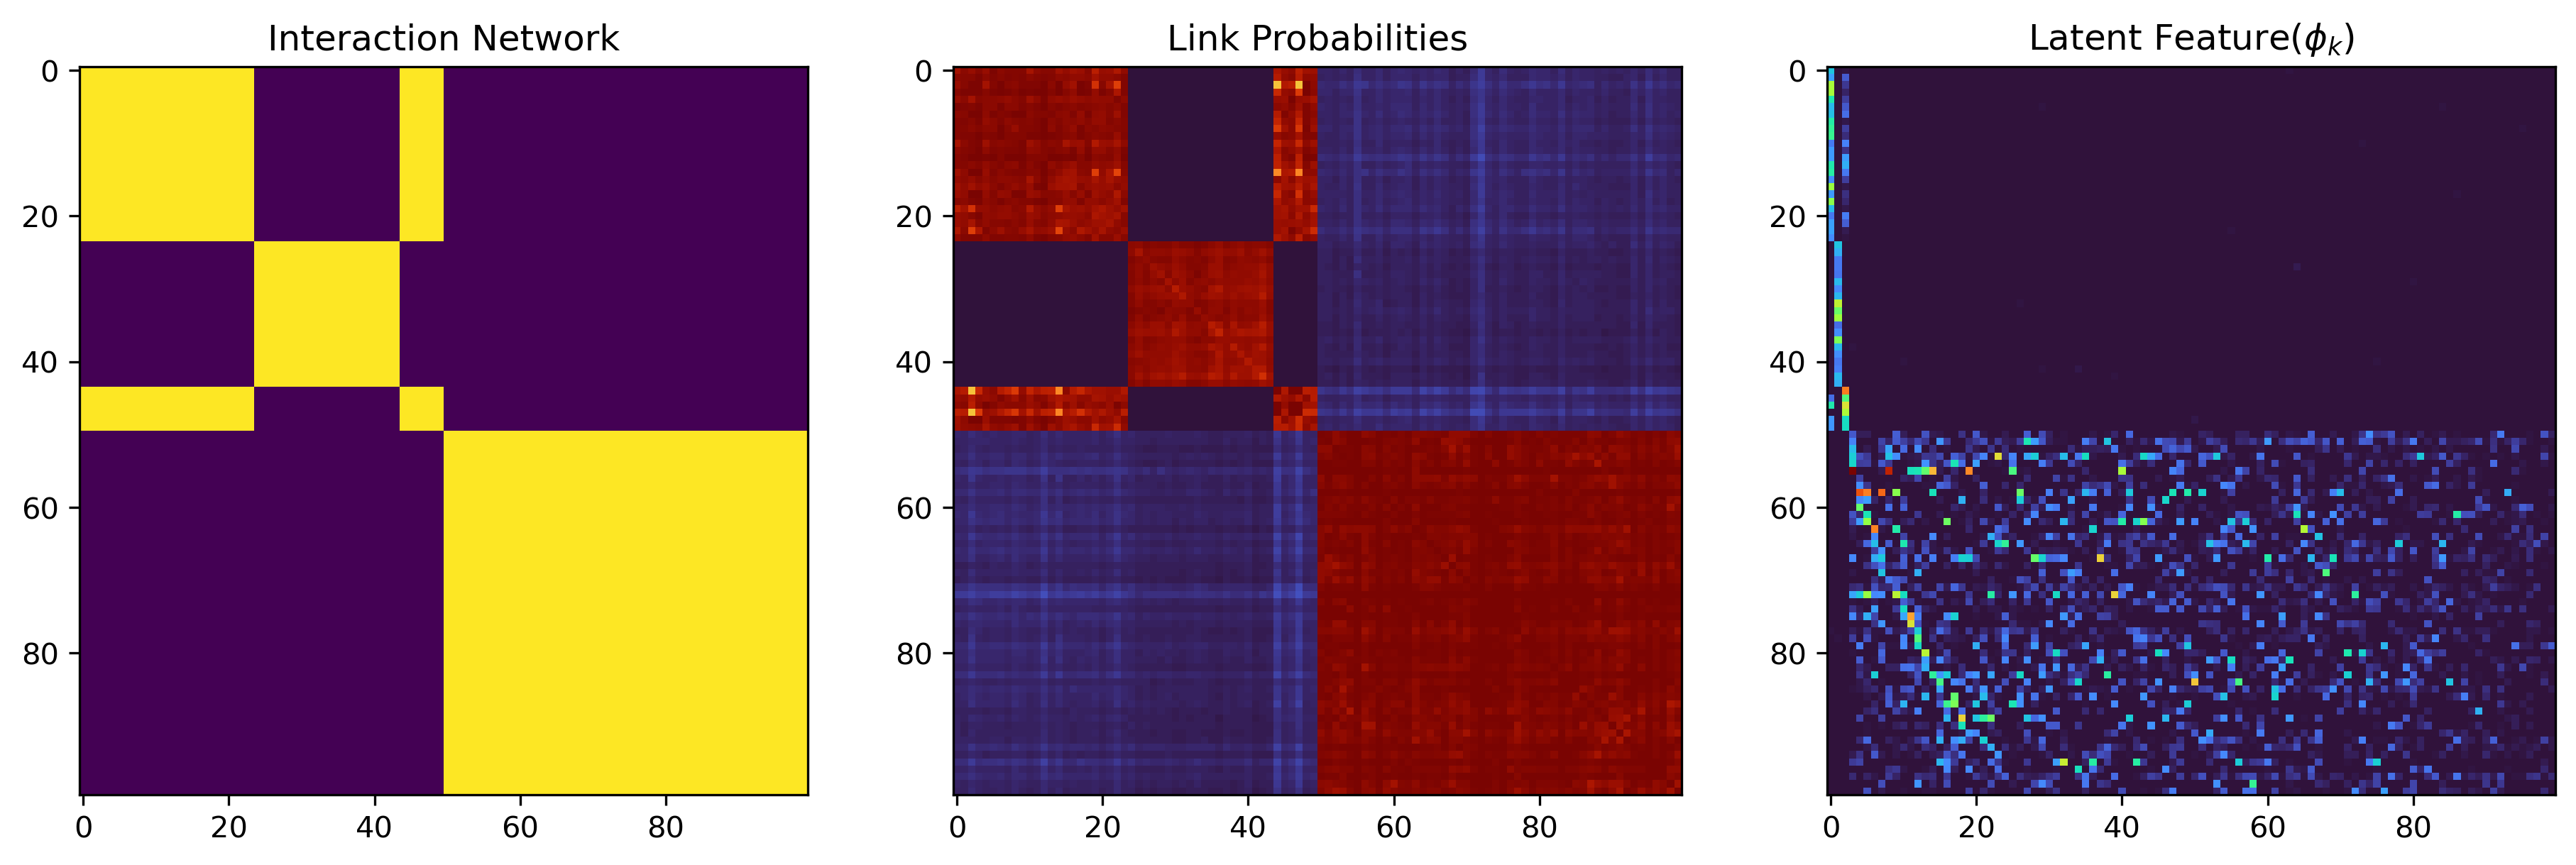

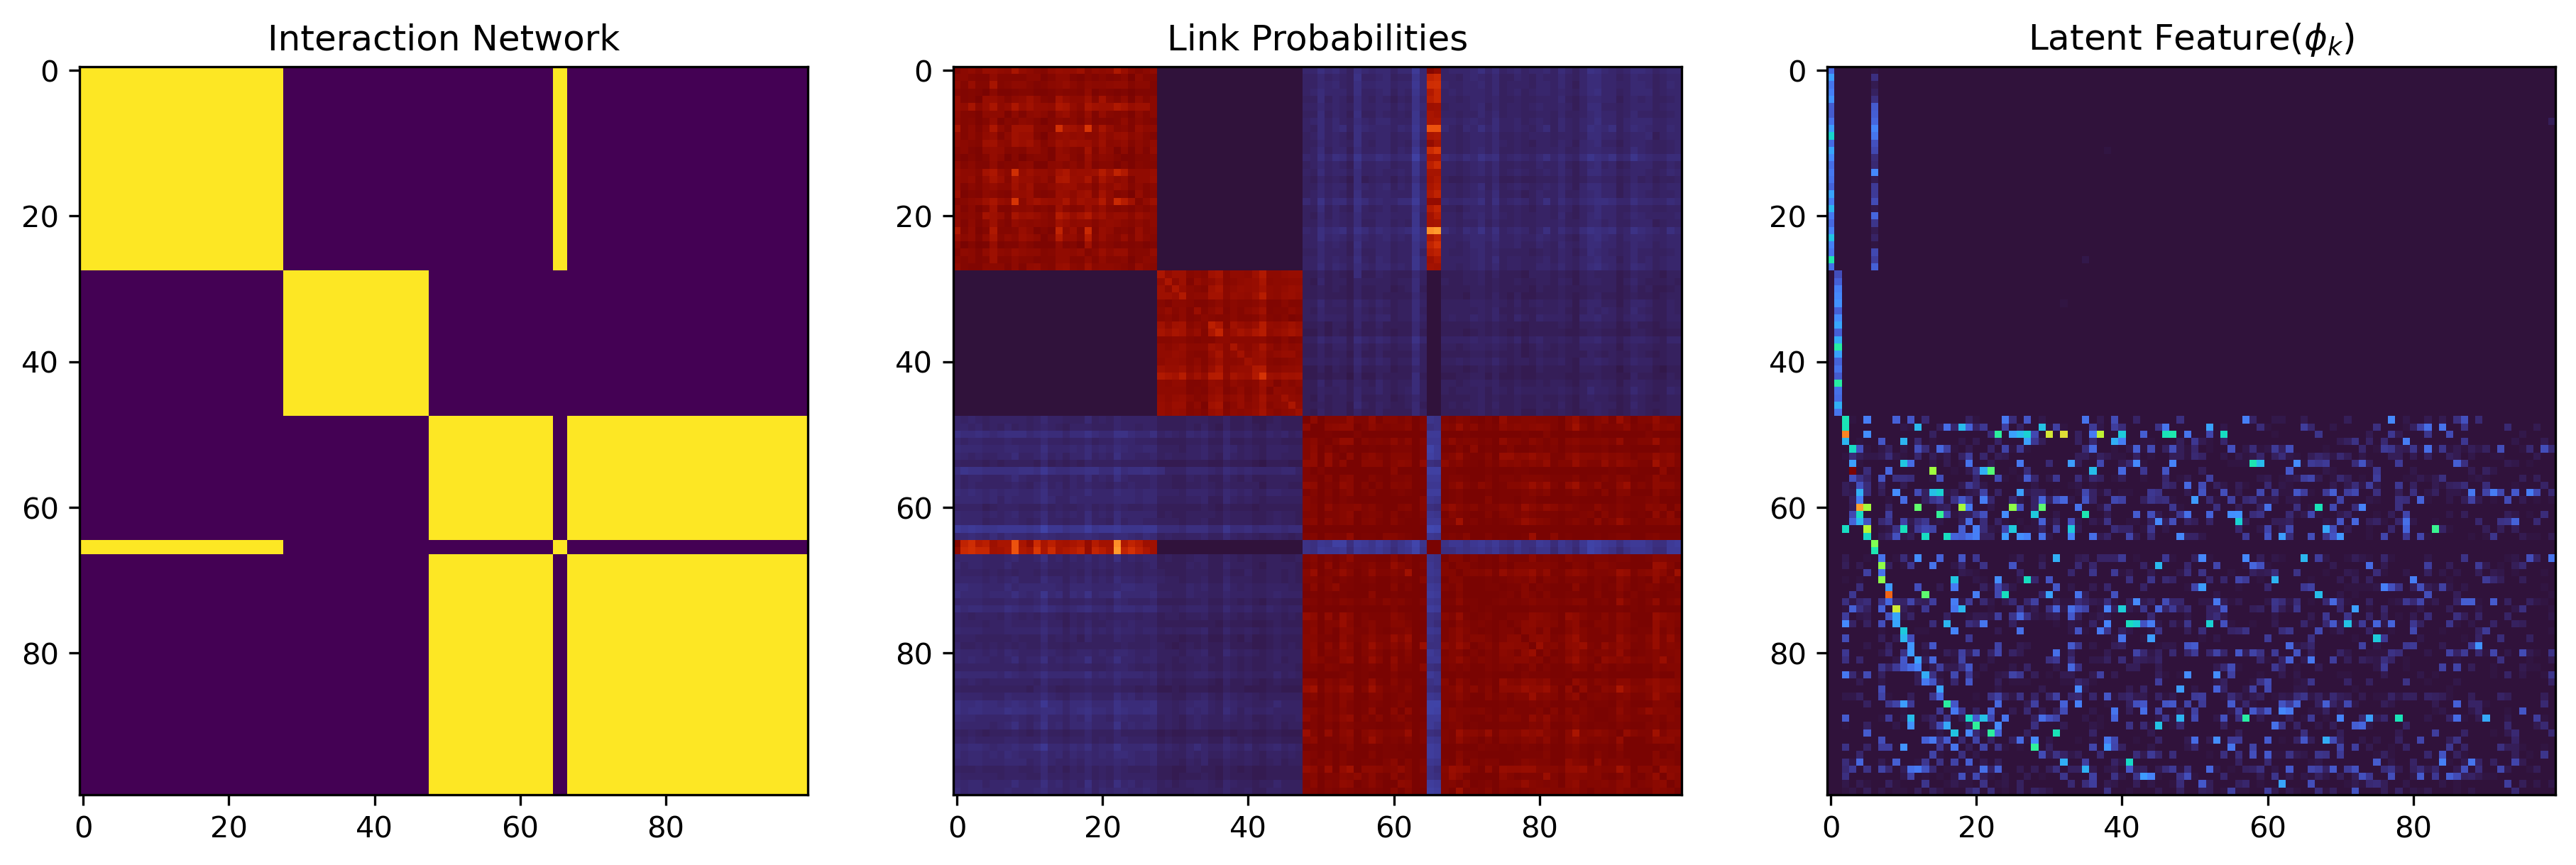

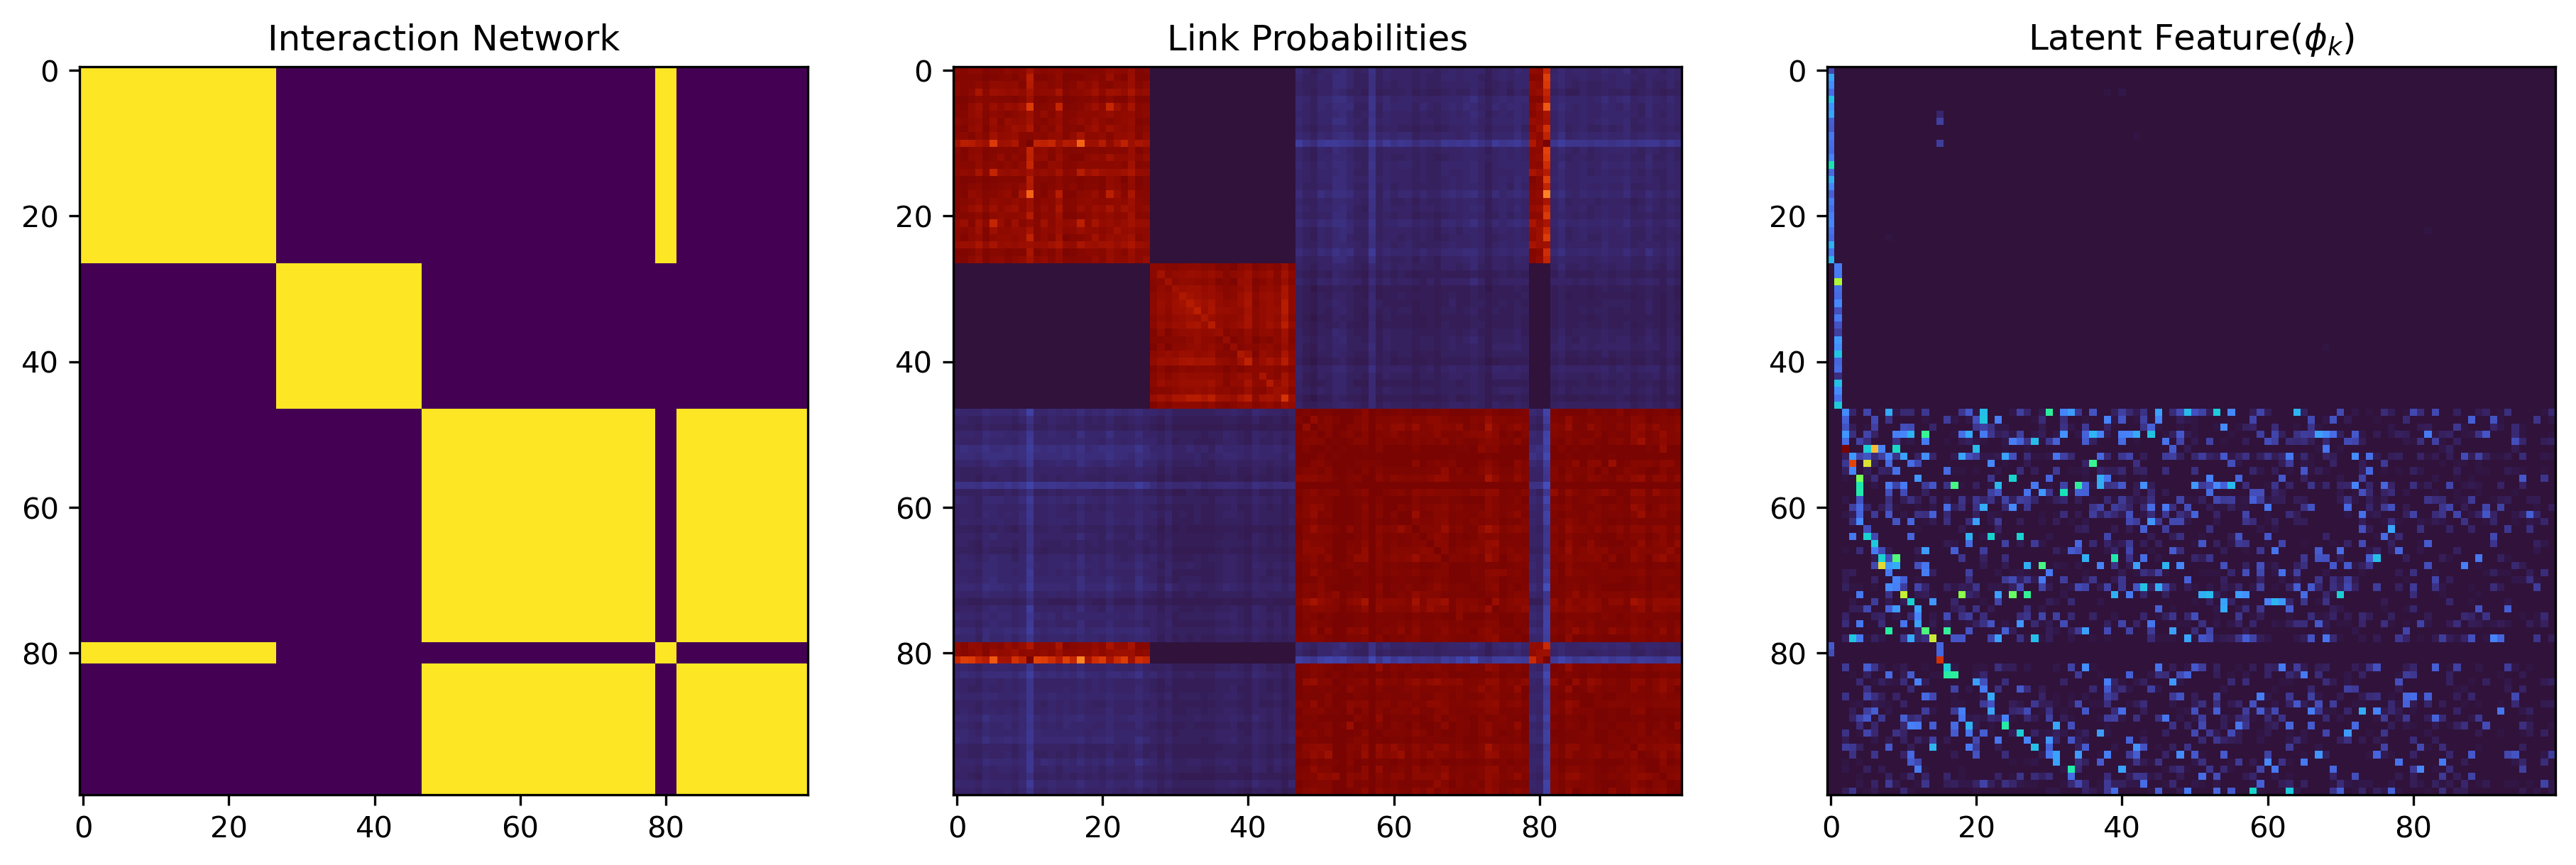

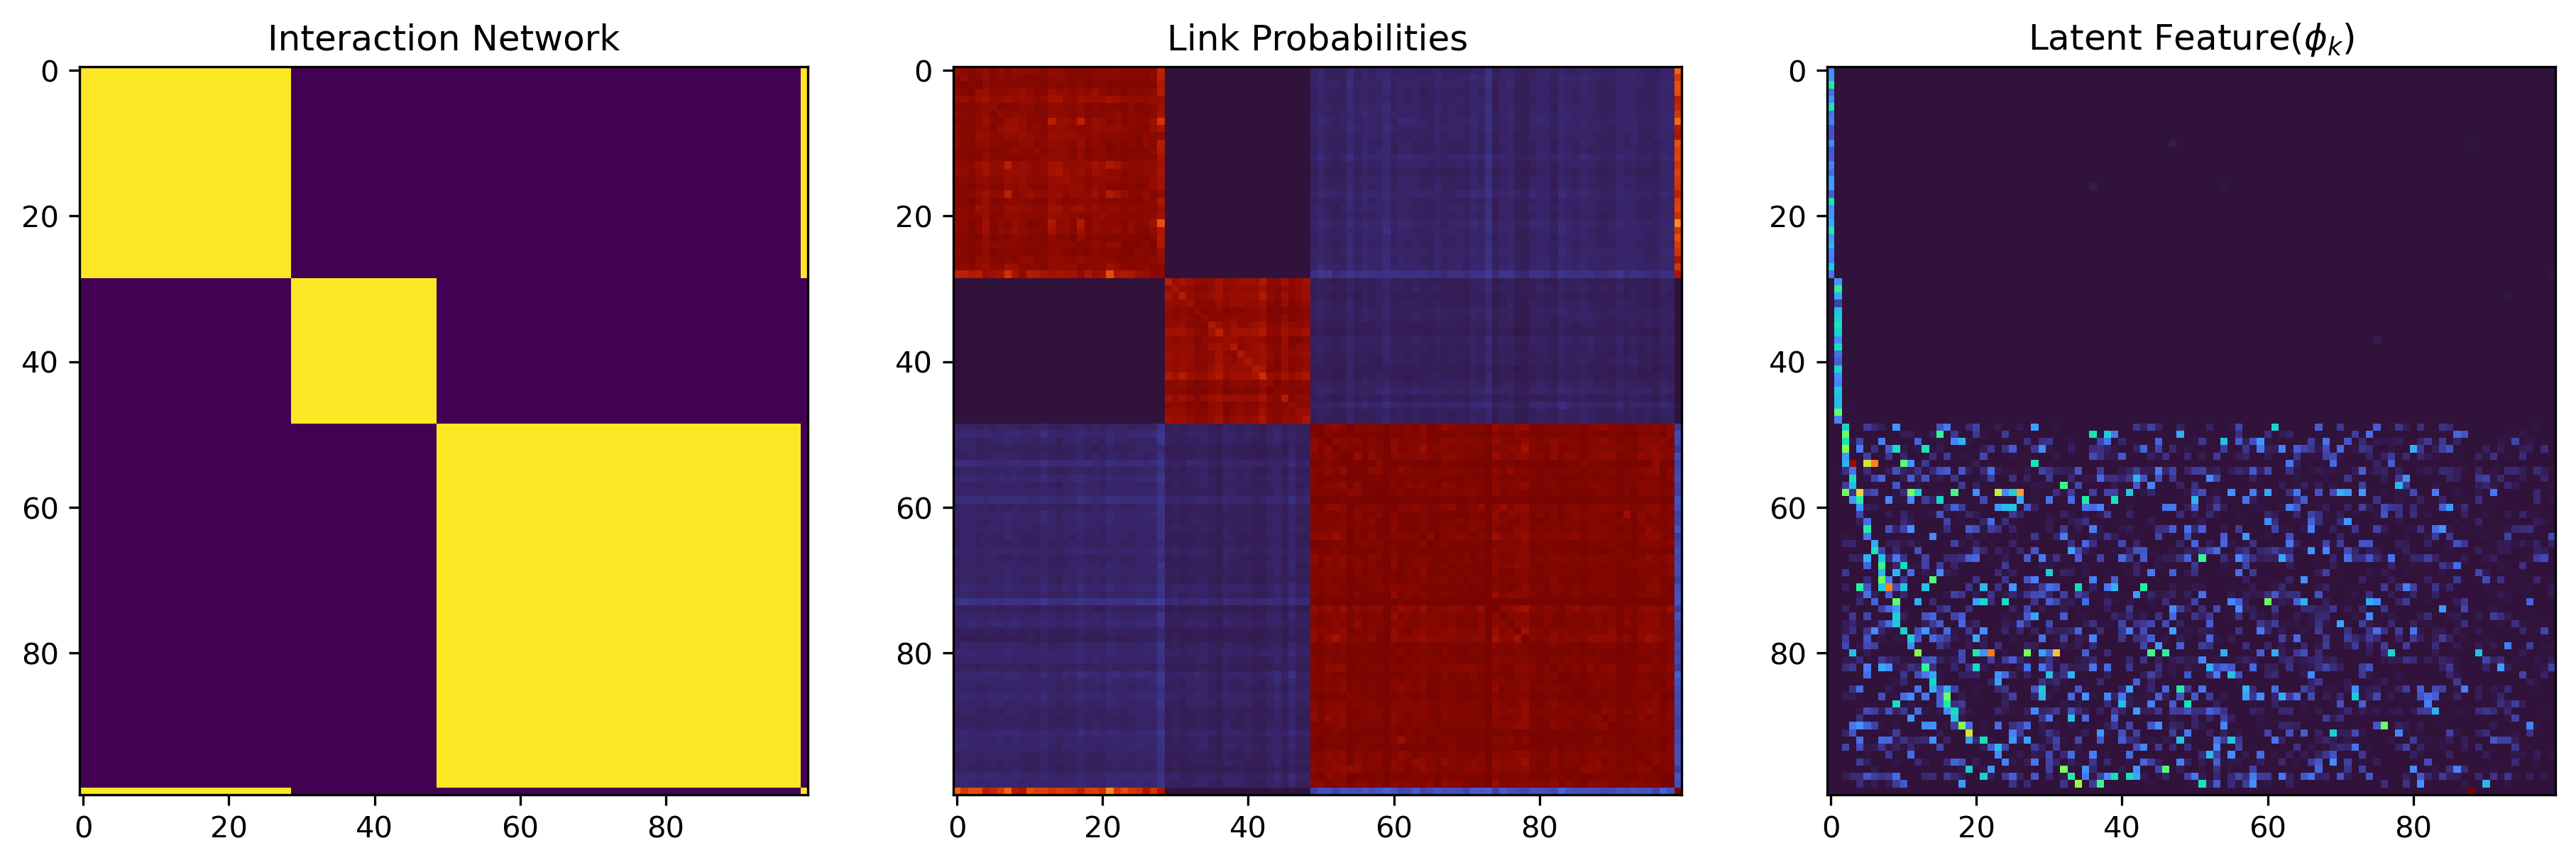

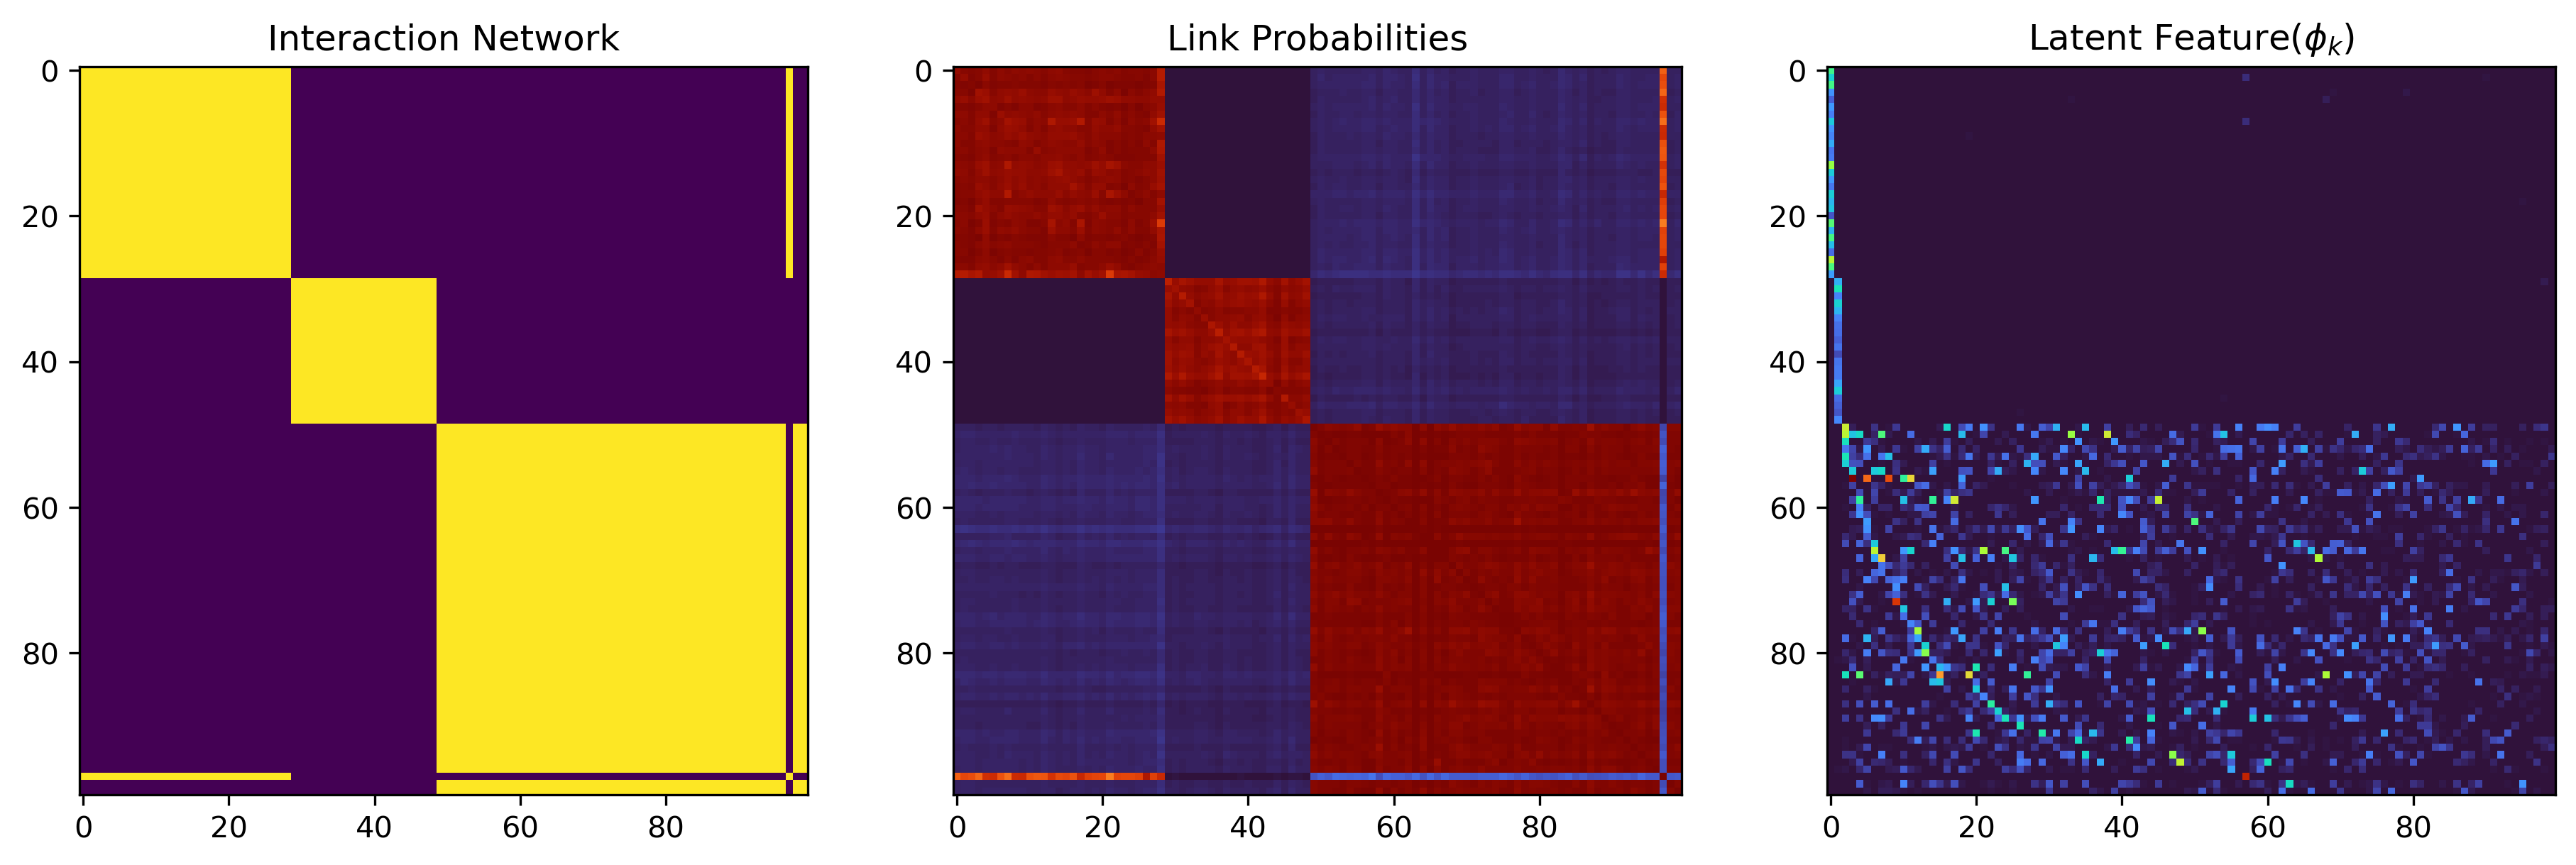

In [7]:
m_idx, n_idx = torch.nonzero(syn_data, as_tuple=True)
X = syn_data[m_idx, n_idx]
AA = syn_data + syn_data.T + torch.eye(len(syn_data))

model = HGP_EPM(syn_config)
prob_sample = torch.zeros(syn_config.N, syn_config.N)

progress = tqdm(range(syn_config.burnin + syn_config.collection))
for i in progress:
    x_ik_ddot = model.do_inference(m_idx, n_idx, X)
    
    K_positive = len(torch.sum(x_ik_ddot, dim=0).nonzero())
    
    prob = model.phi @ model.lam_kk @ model.phi.T + syn_config.eps
    prob = 1 - torch.exp(- prob)
    if i > syn_config.burnin:
        prob_sample = prob_sample + prob
        prob_ave = prob_sample / (i - syn_config.burnin)
    else:
        prob_ave = prob
        
    _, rdex = torch.sort(
        torch.sum(x_ik_ddot, dim=0),
        descending=True
    )
    _, z = torch.max(x_ik_ddot[:, rdex], dim=-1)
    _, Rank_dex = torch.sort(z)
    
    K_hardassignment = len(torch.unique(z))
    
    latent_feature = model.phi[Rank_dex][:, rdex] @ (torch.diag(model.r[rdex]) ** 0.5)
    latent_feature = torch.log(latent_feature + 9.99e-1)
    
    if (i+1)%250 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
        axs[0].set_title('Interaction Network')
        axs[0].imshow(AA[Rank_dex][:, Rank_dex])

        axs[1].set_title('Link Probabilities')
        axs[1].imshow(prob_ave[Rank_dex][:, Rank_dex], cmap='turbo')

        axs[2].set_title(r'Latent Feature($\phi_k$)')
        axs[2].imshow(latent_feature, cmap='turbo')
        
    progress.set_postfix({'K_plus': K_positive, 'K_hard': K_hardassignment, 'gamma0': model.gamma_0})

## Model Protein Network

100%|██████████| 3000/3000 [49:02<00:00,  1.02it/s, K_plus=94, K_hard=68, gamma0=47.4] 


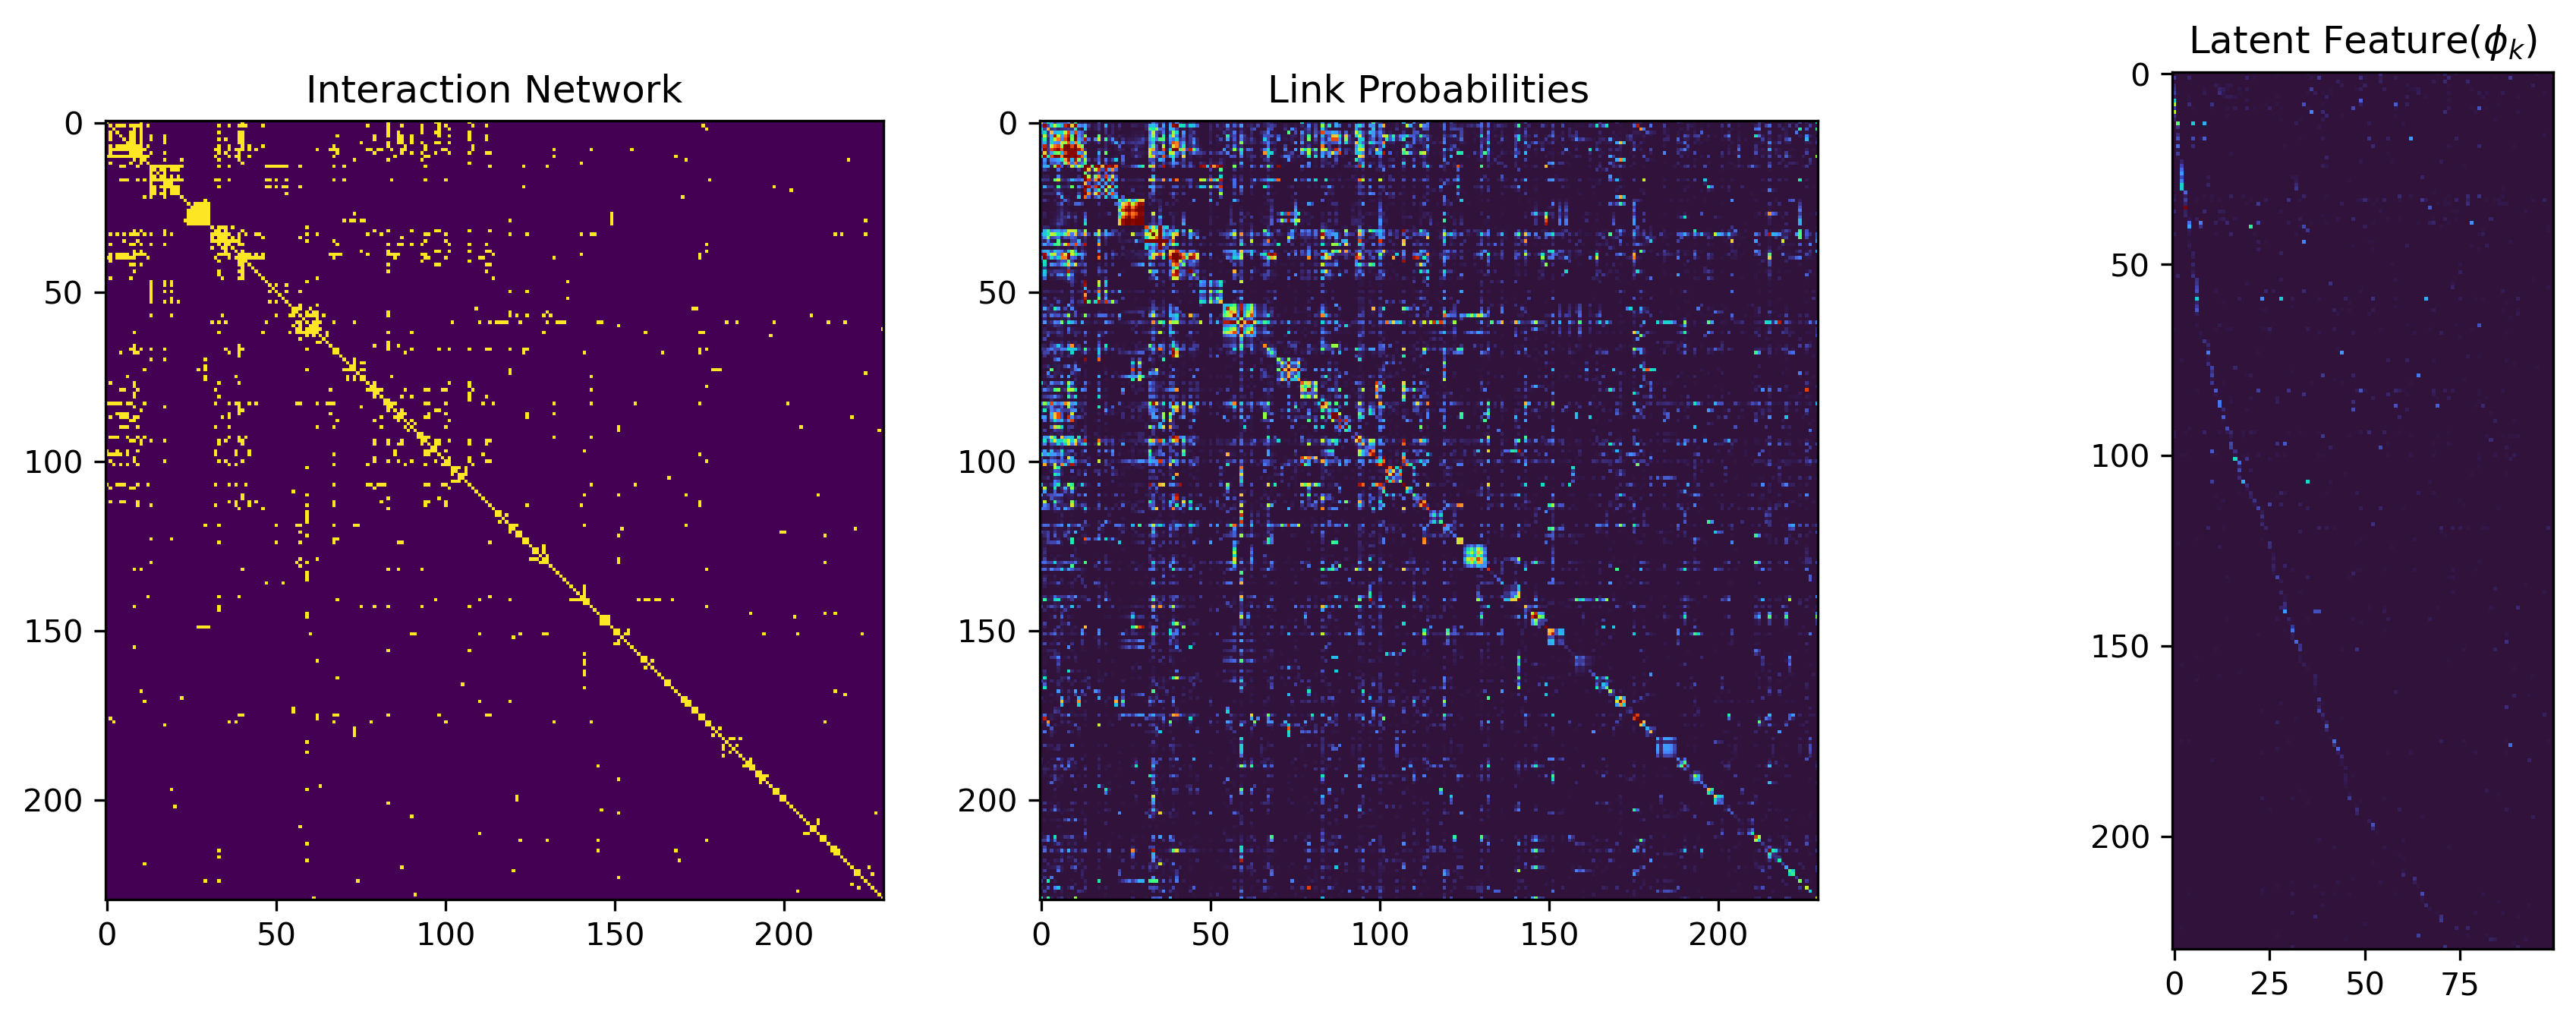

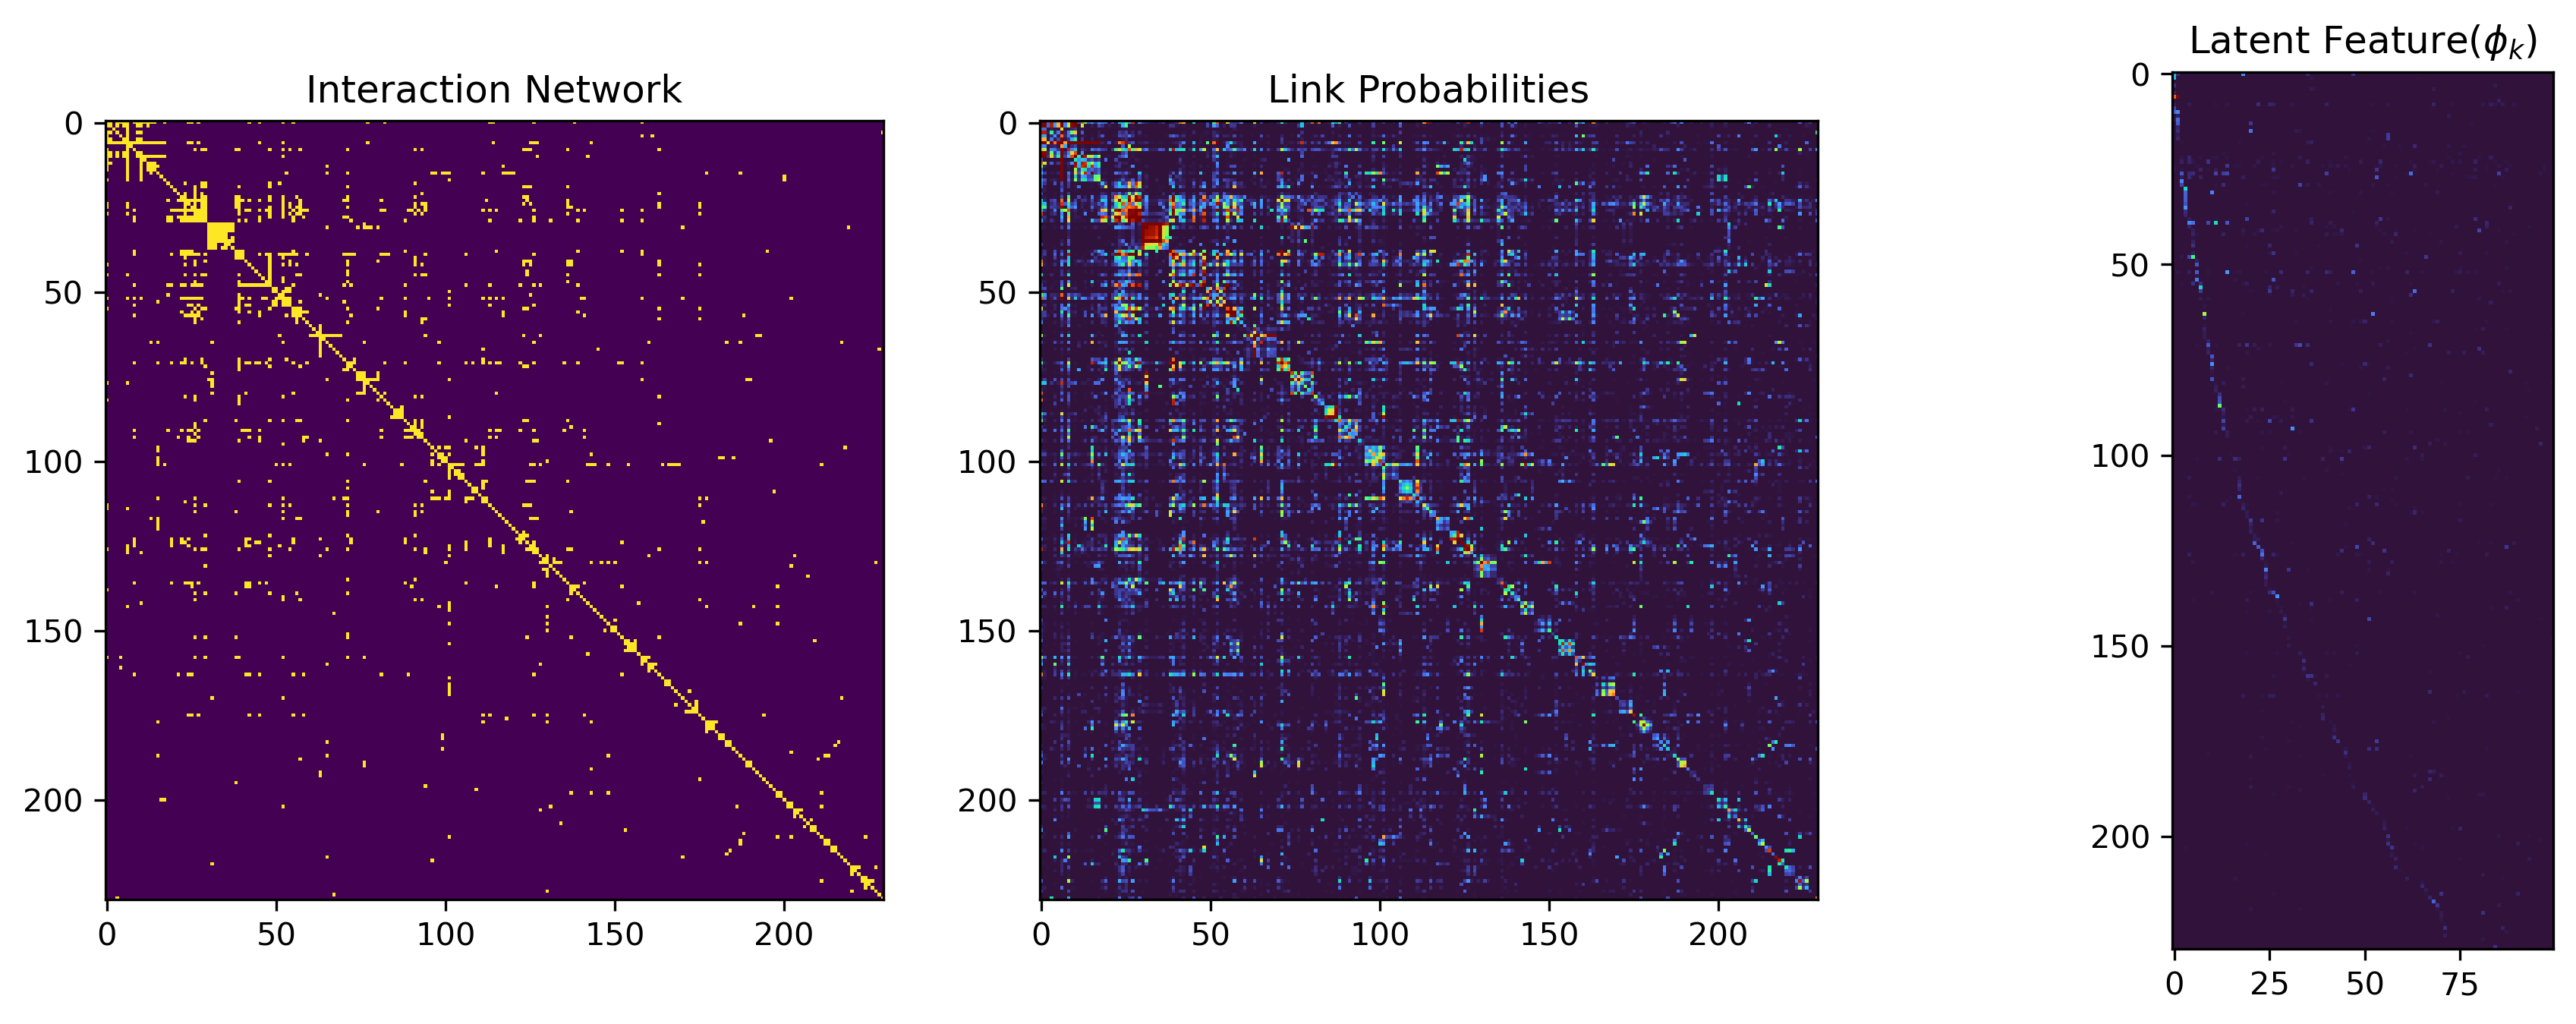

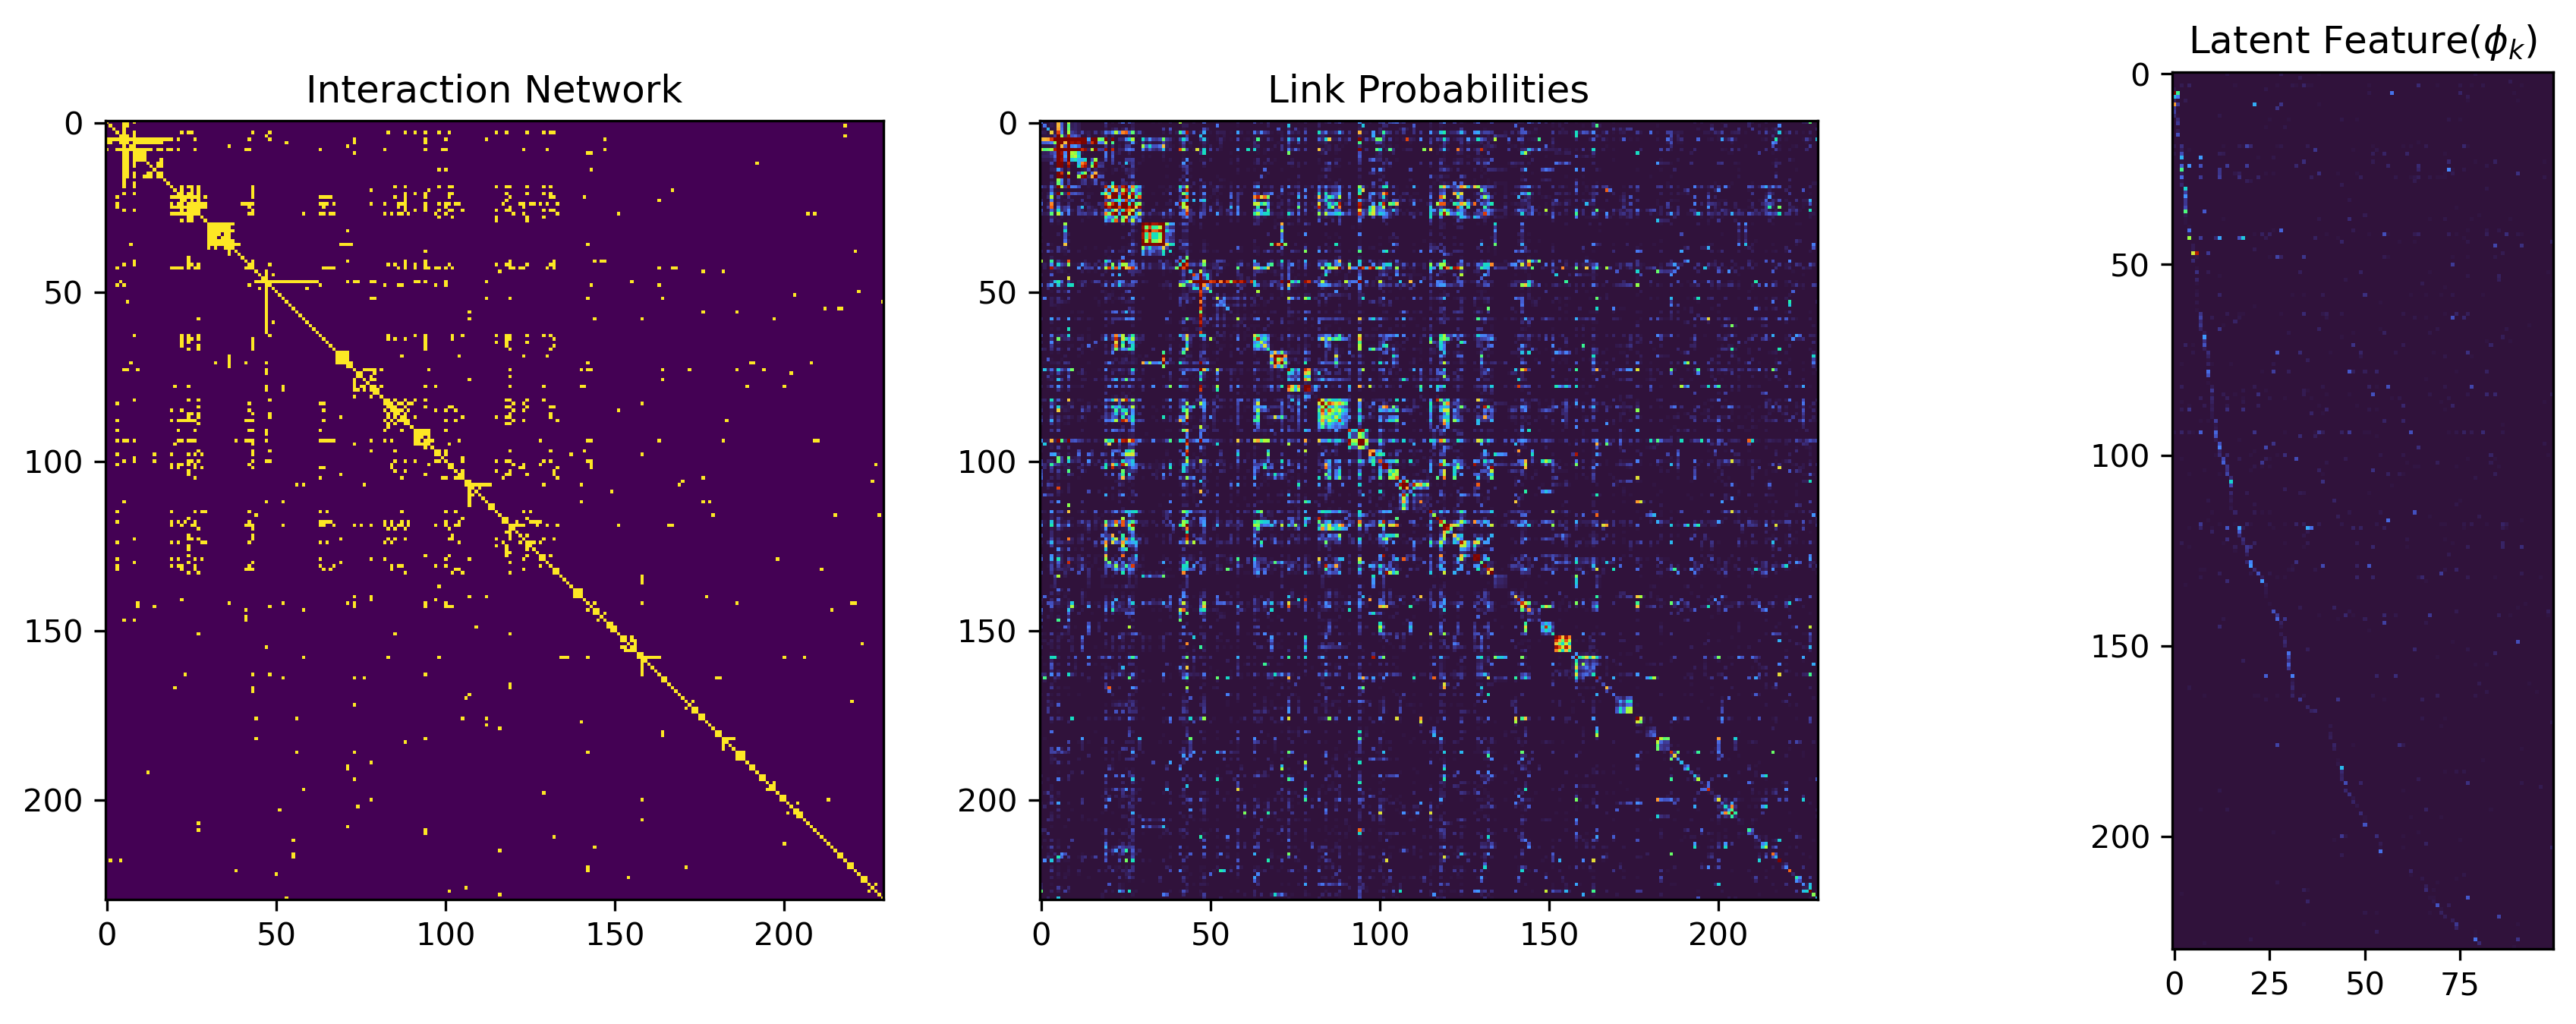

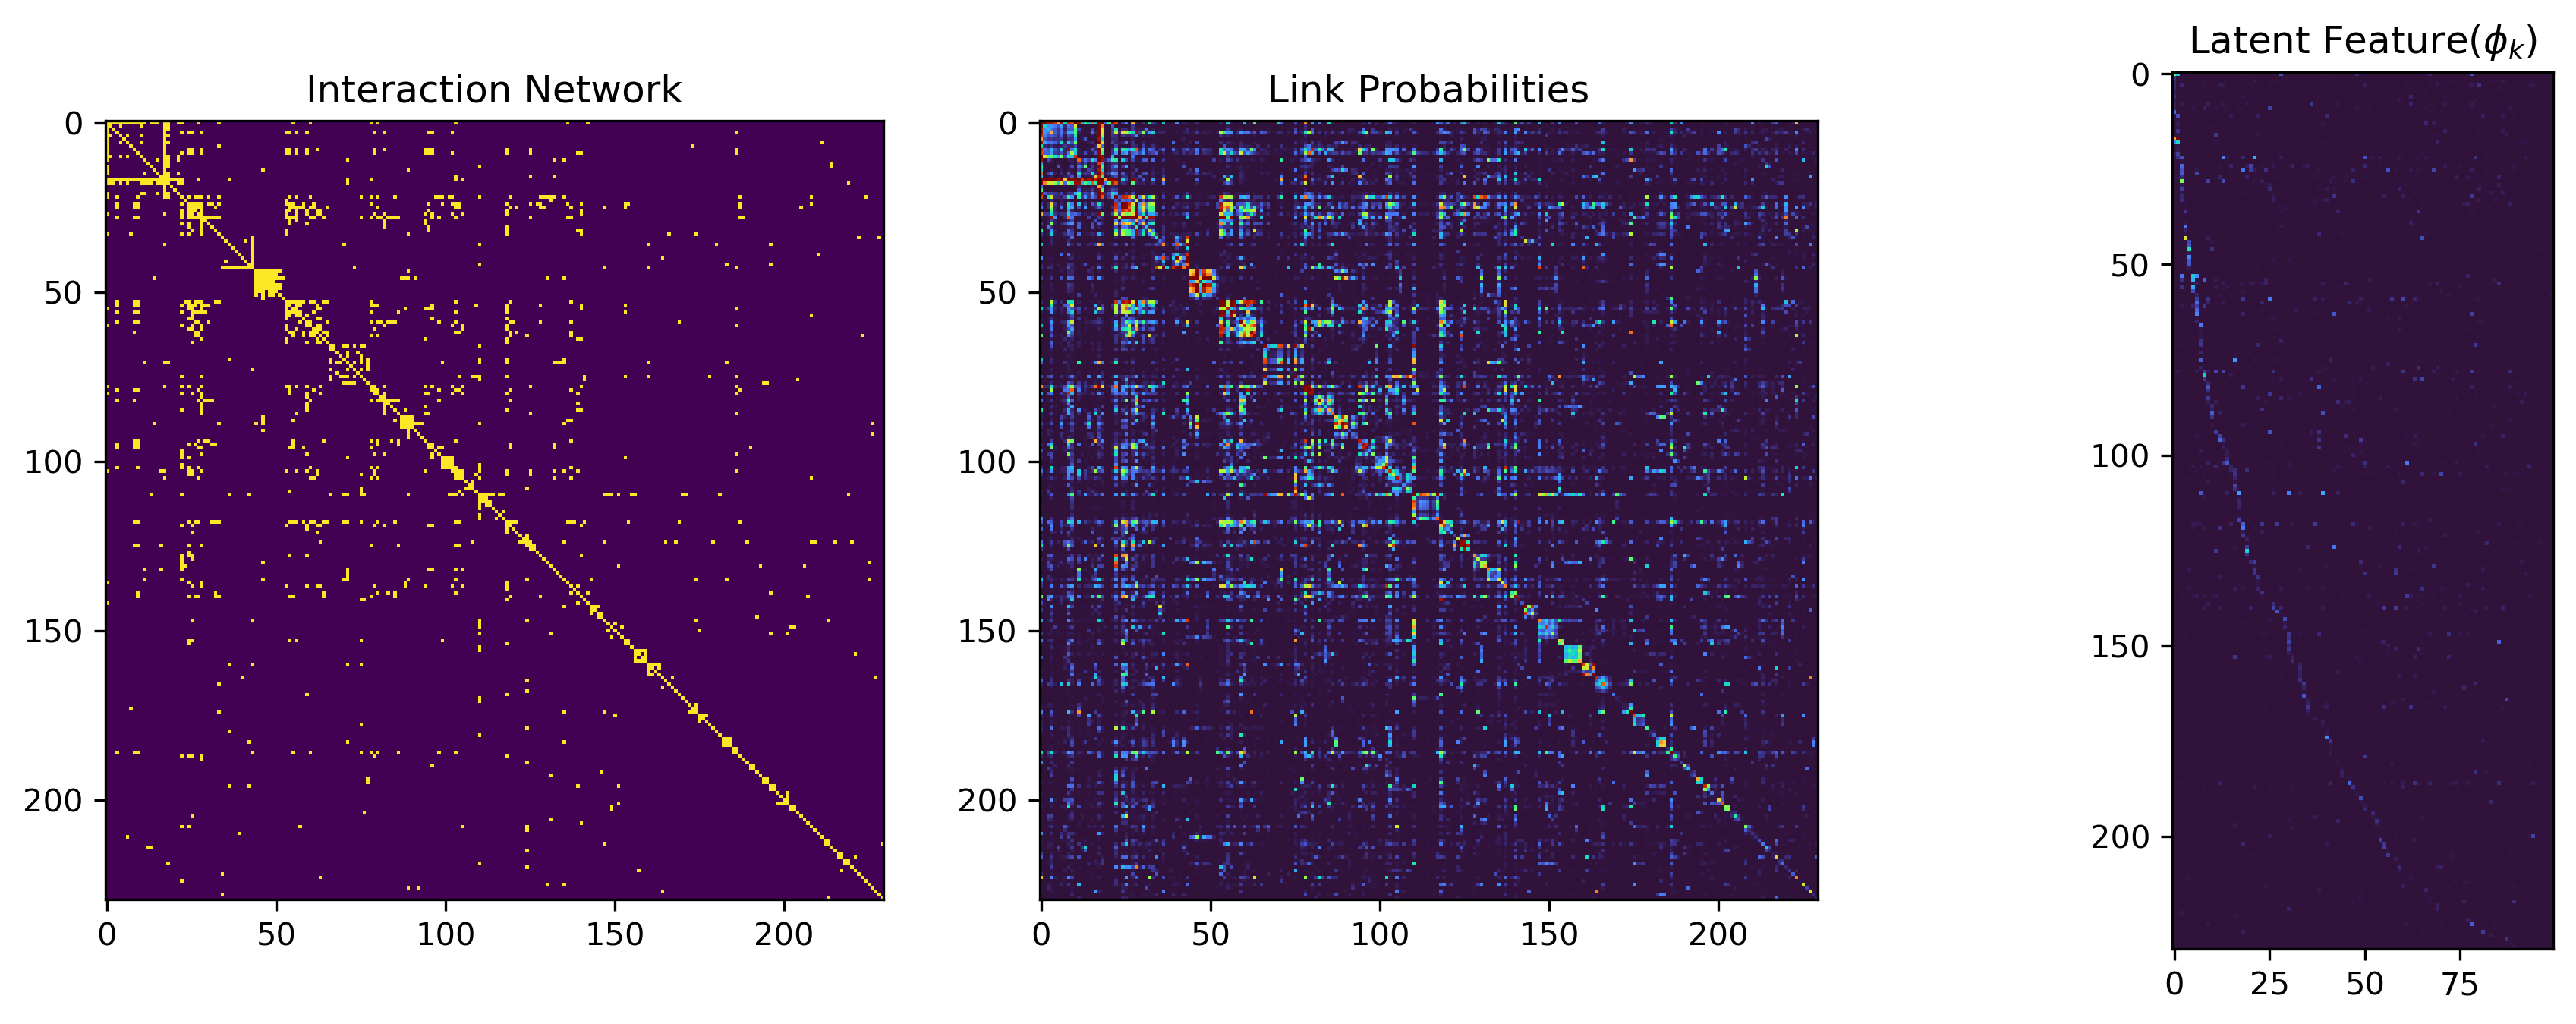

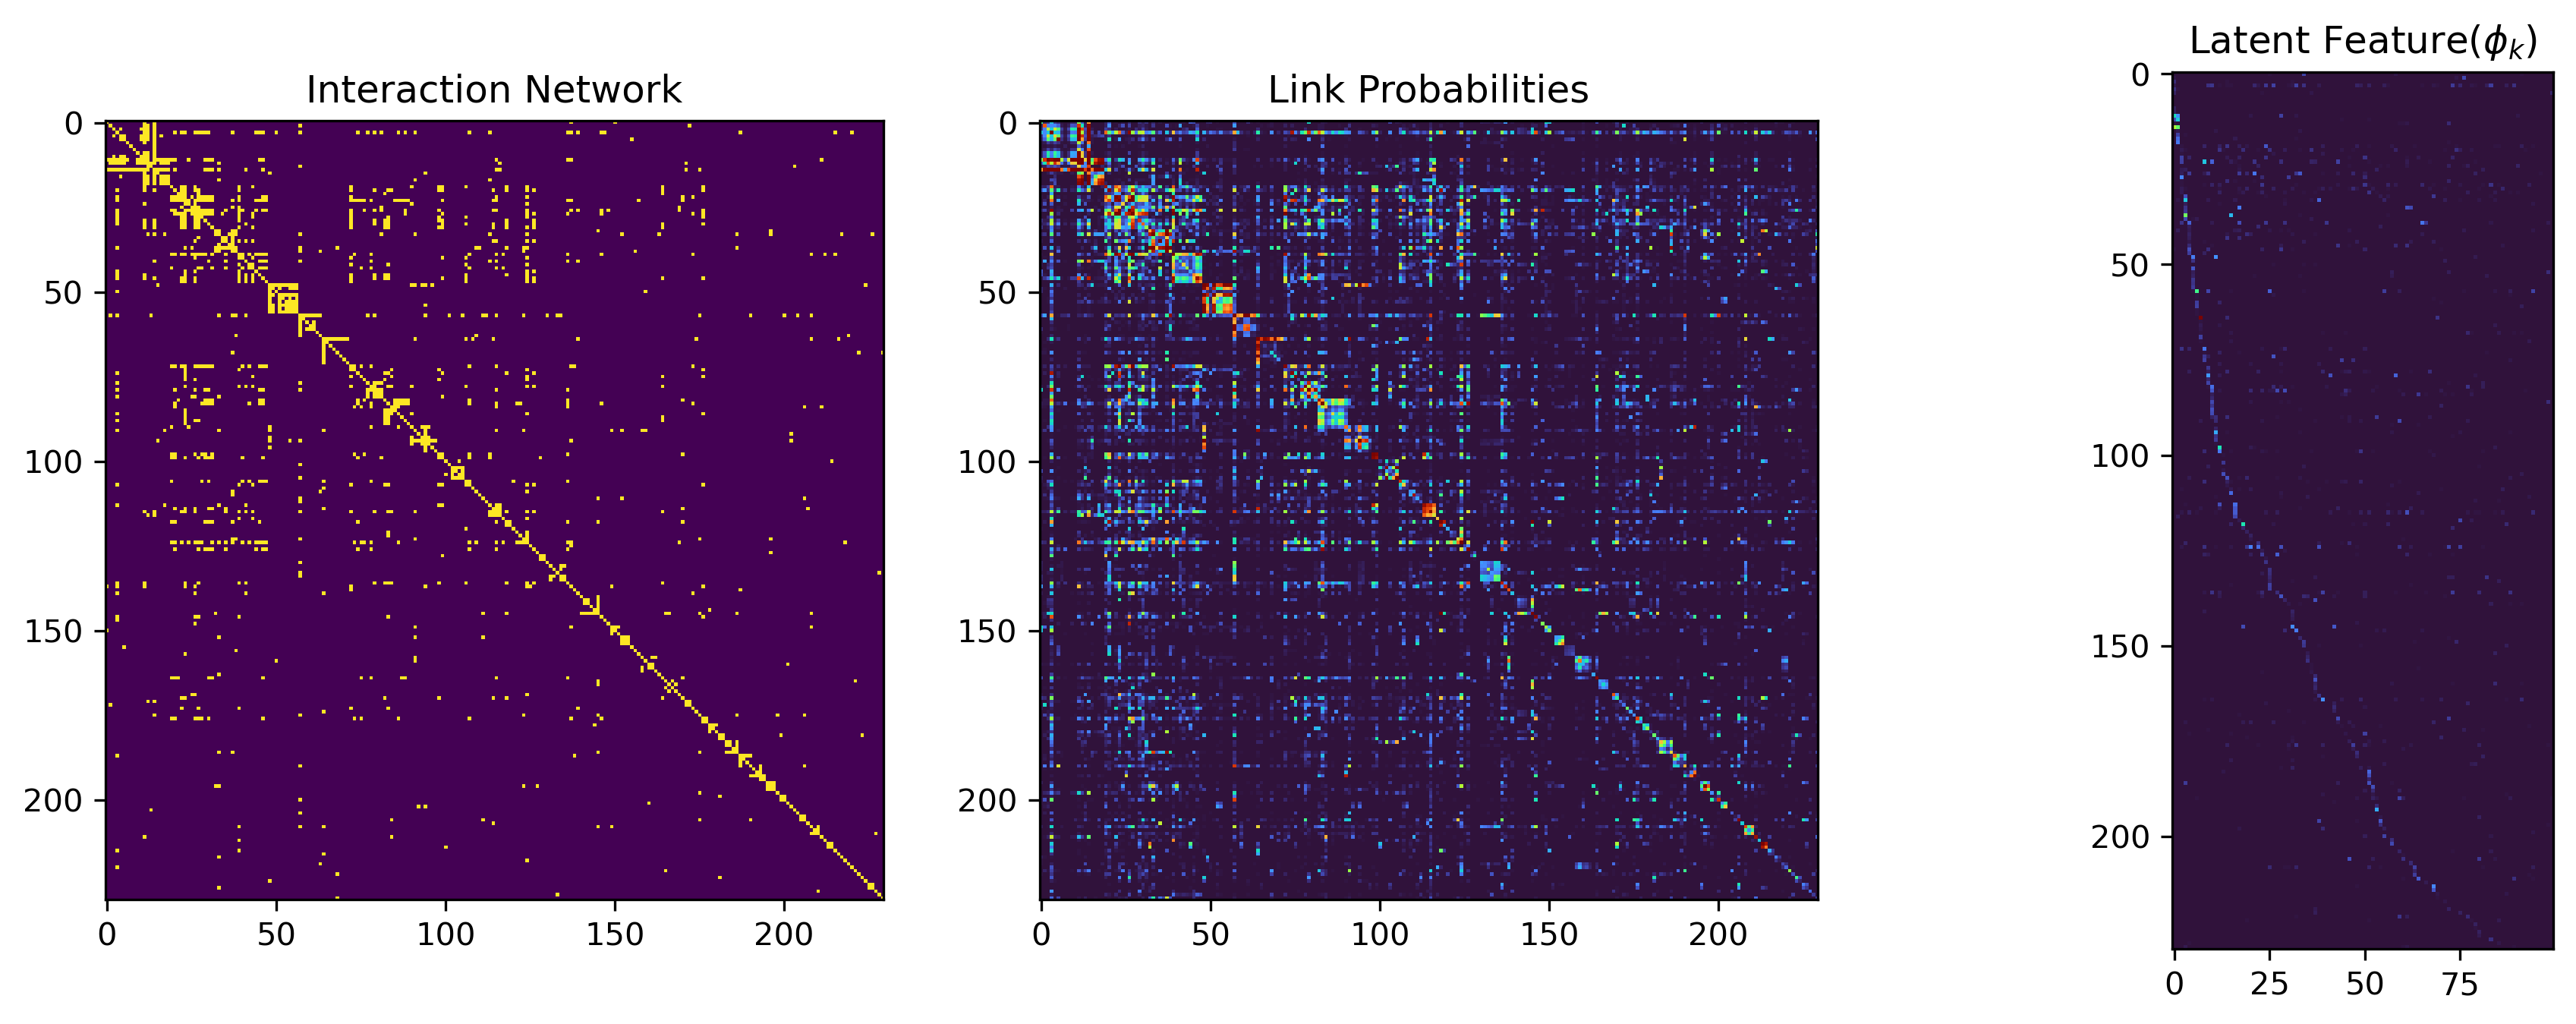

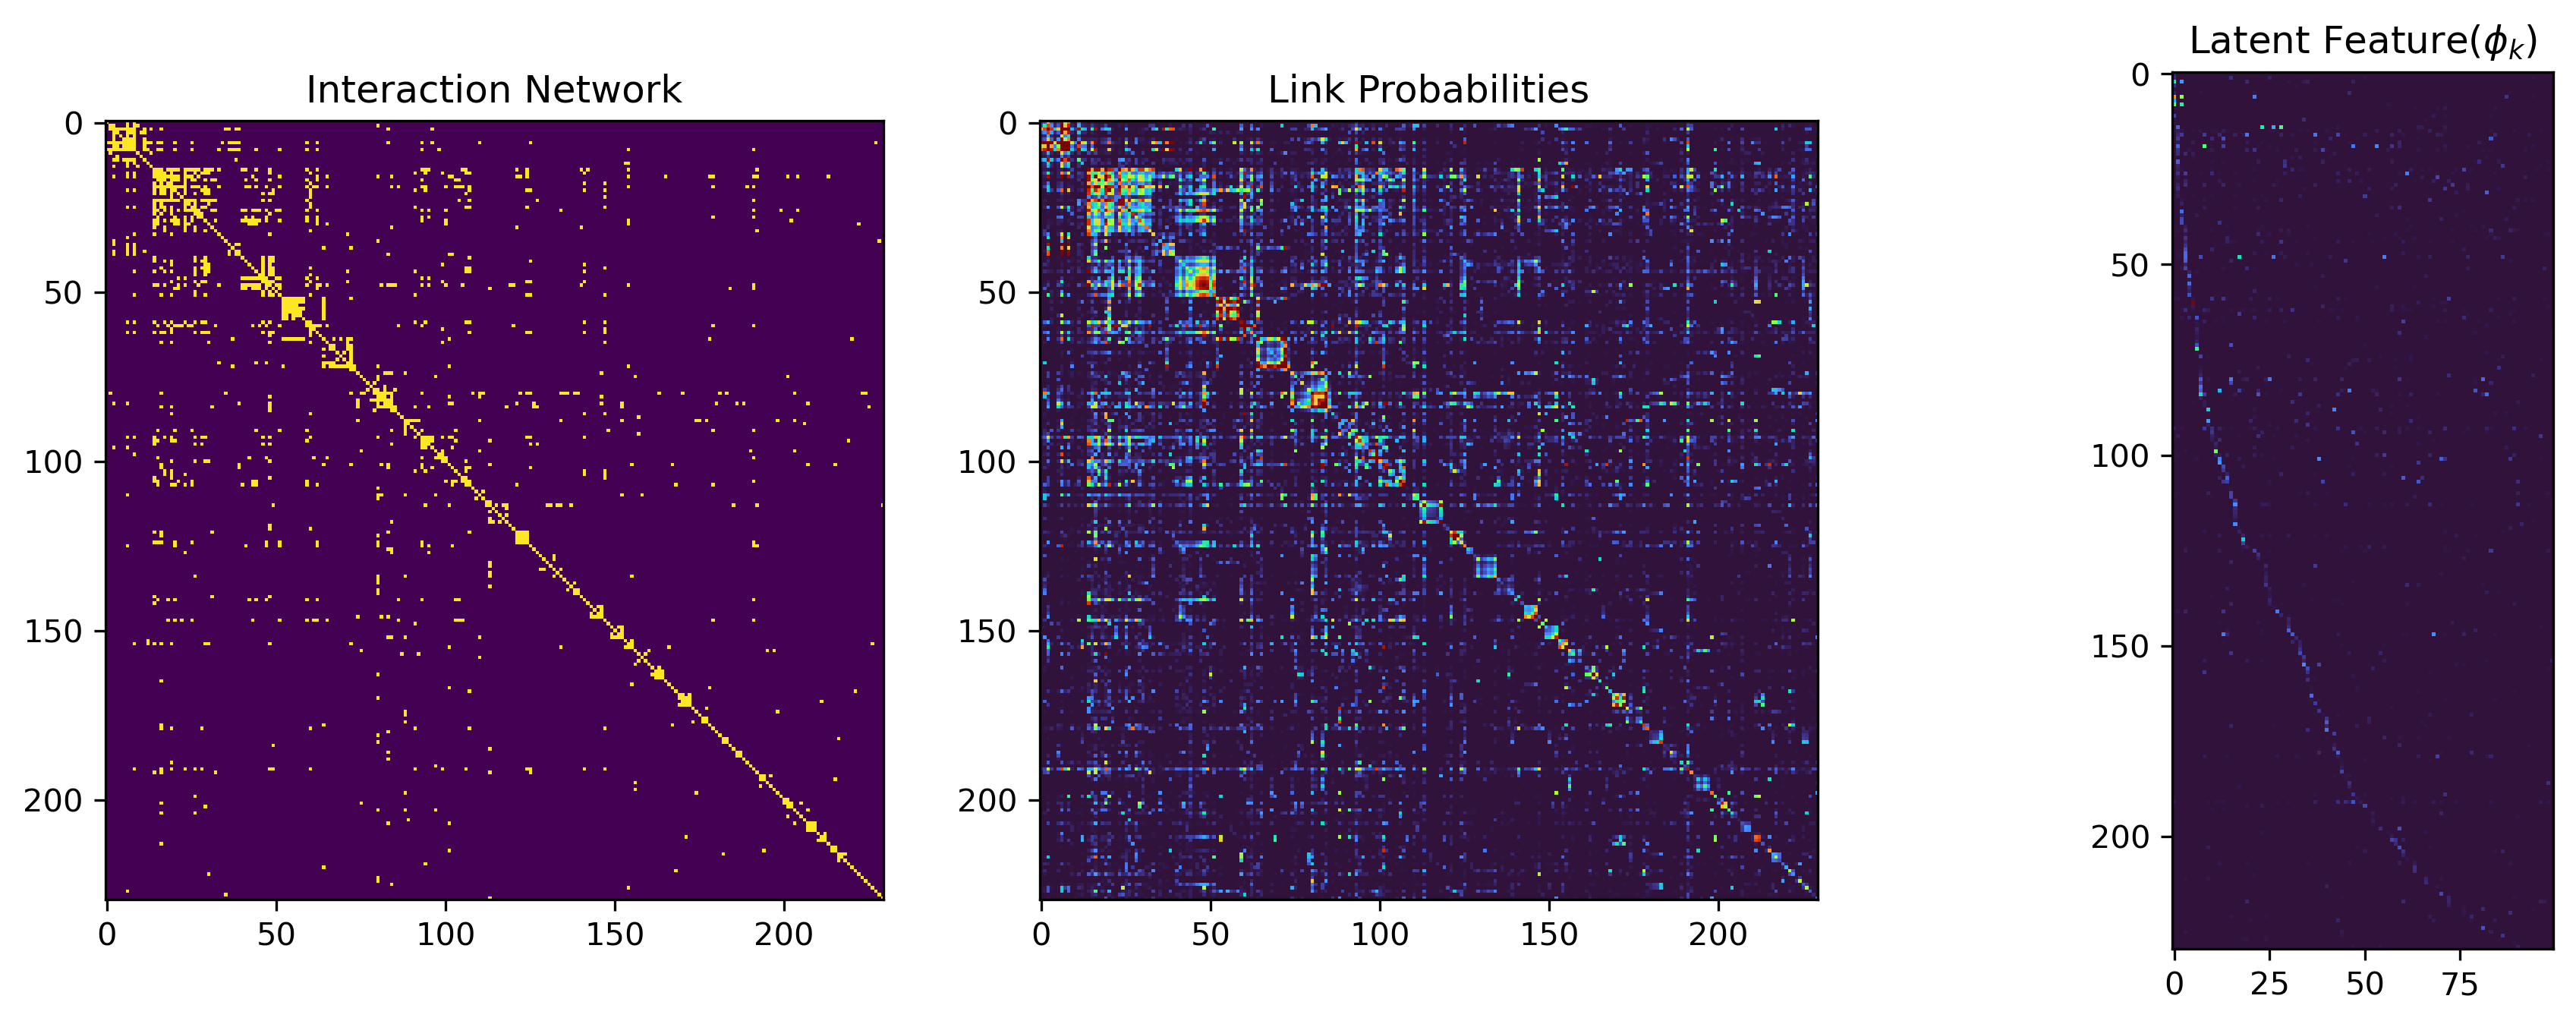

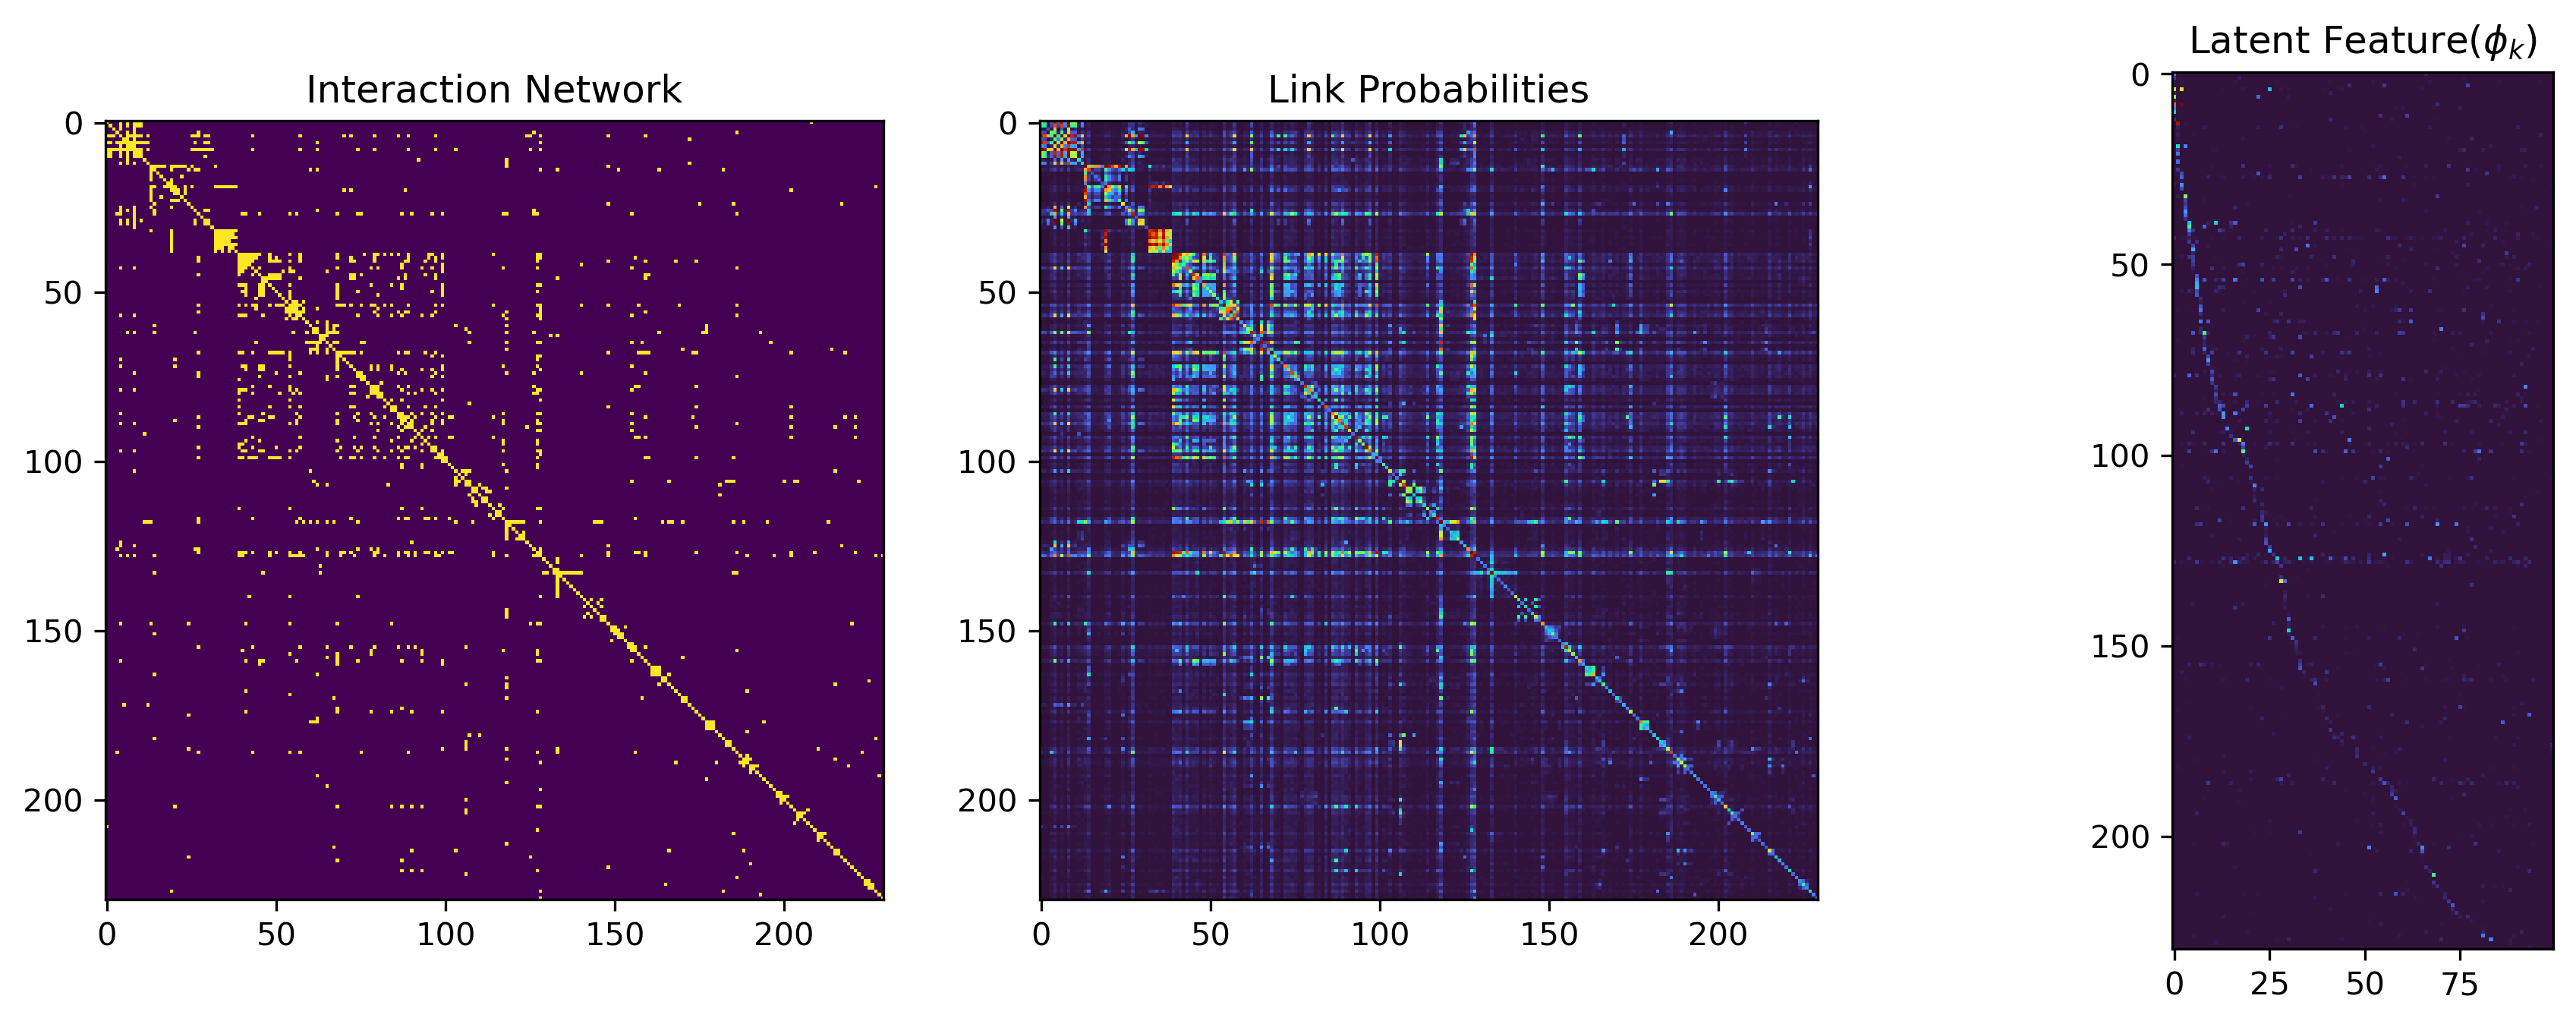

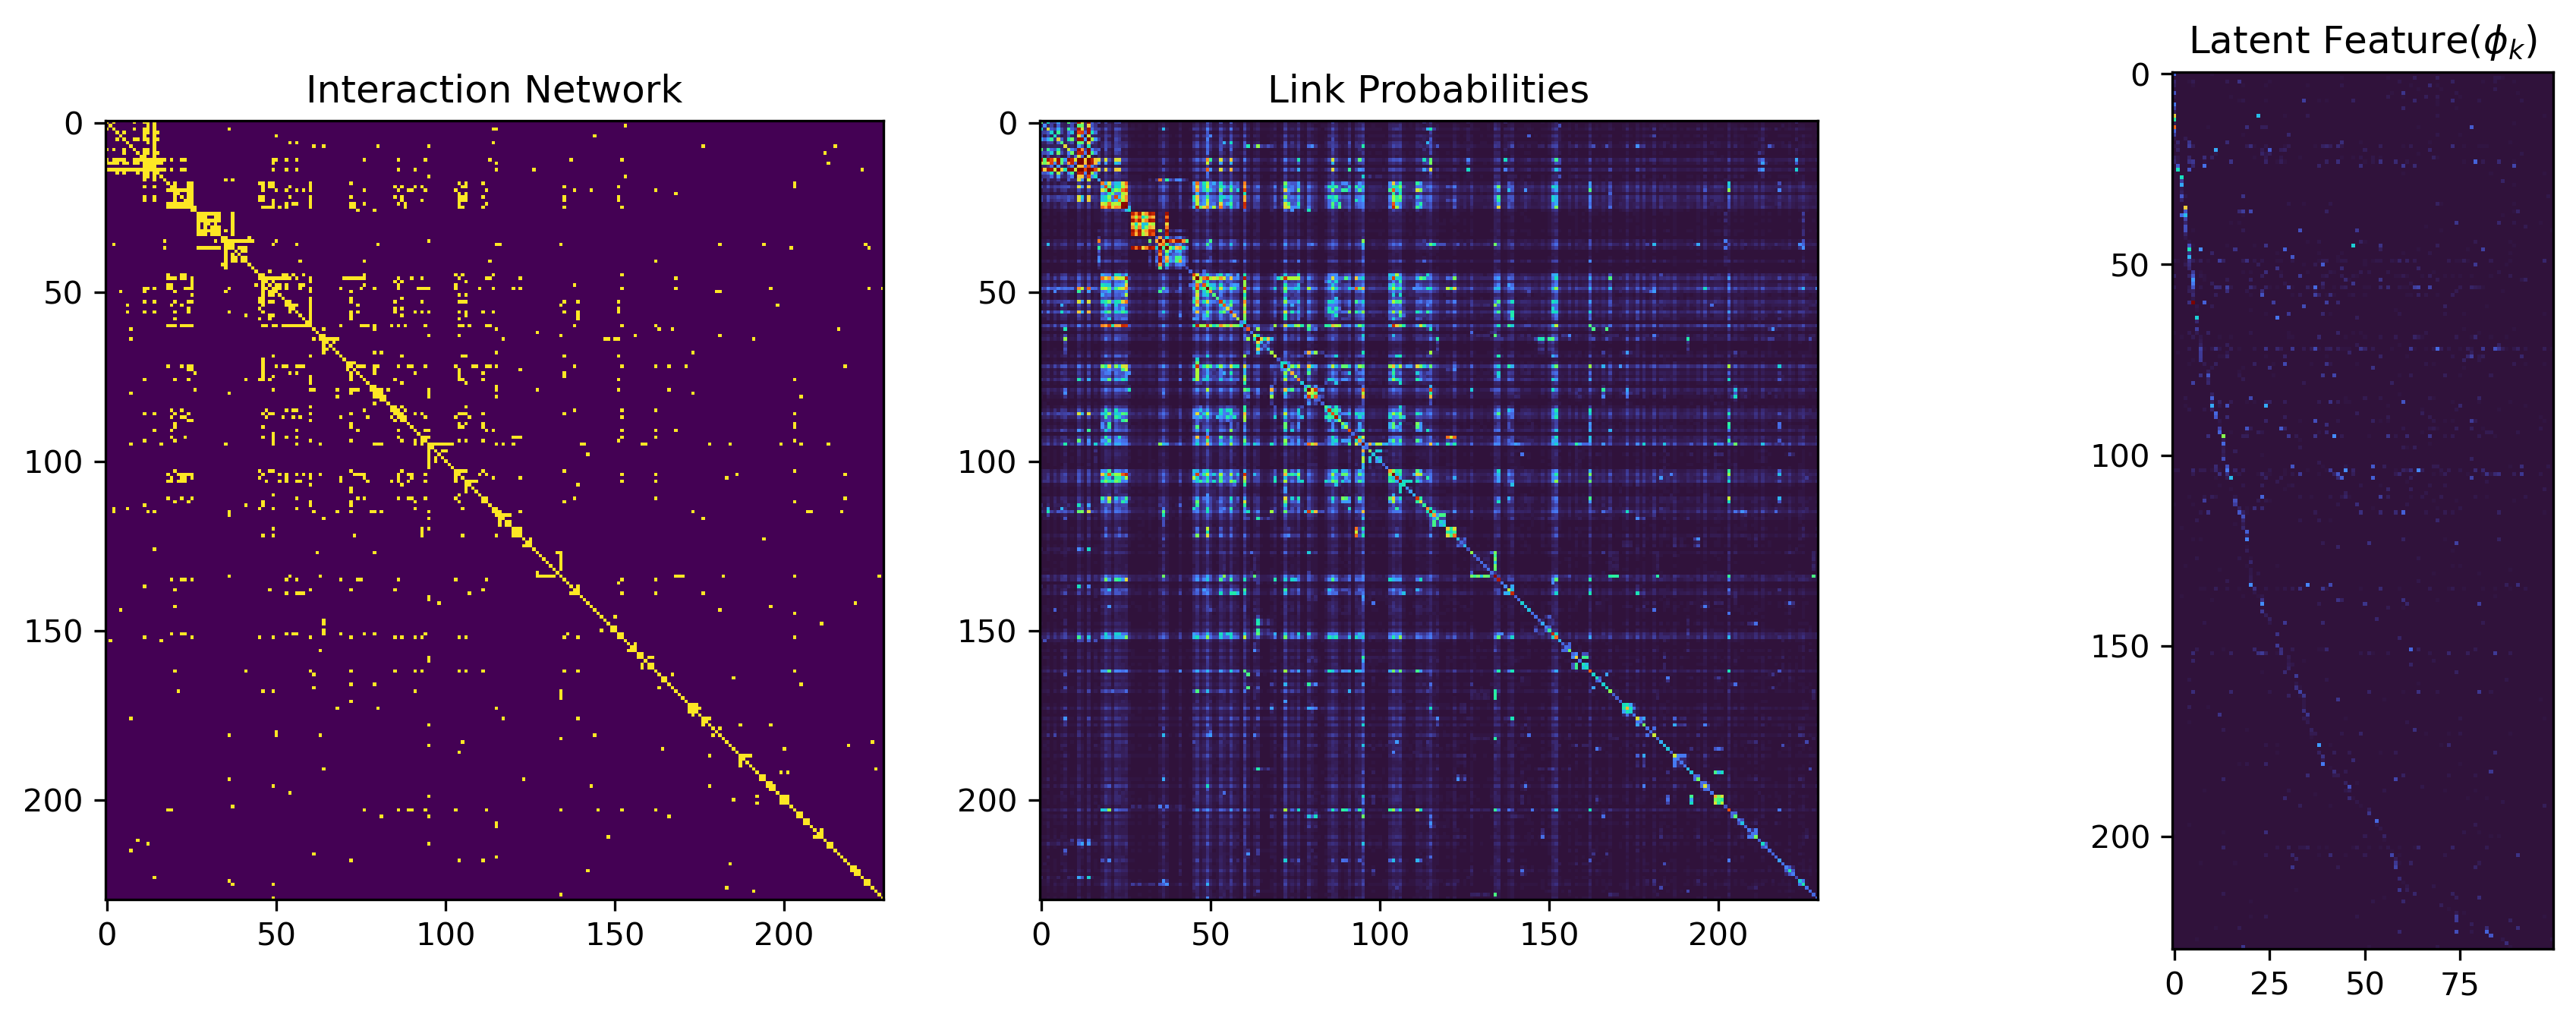

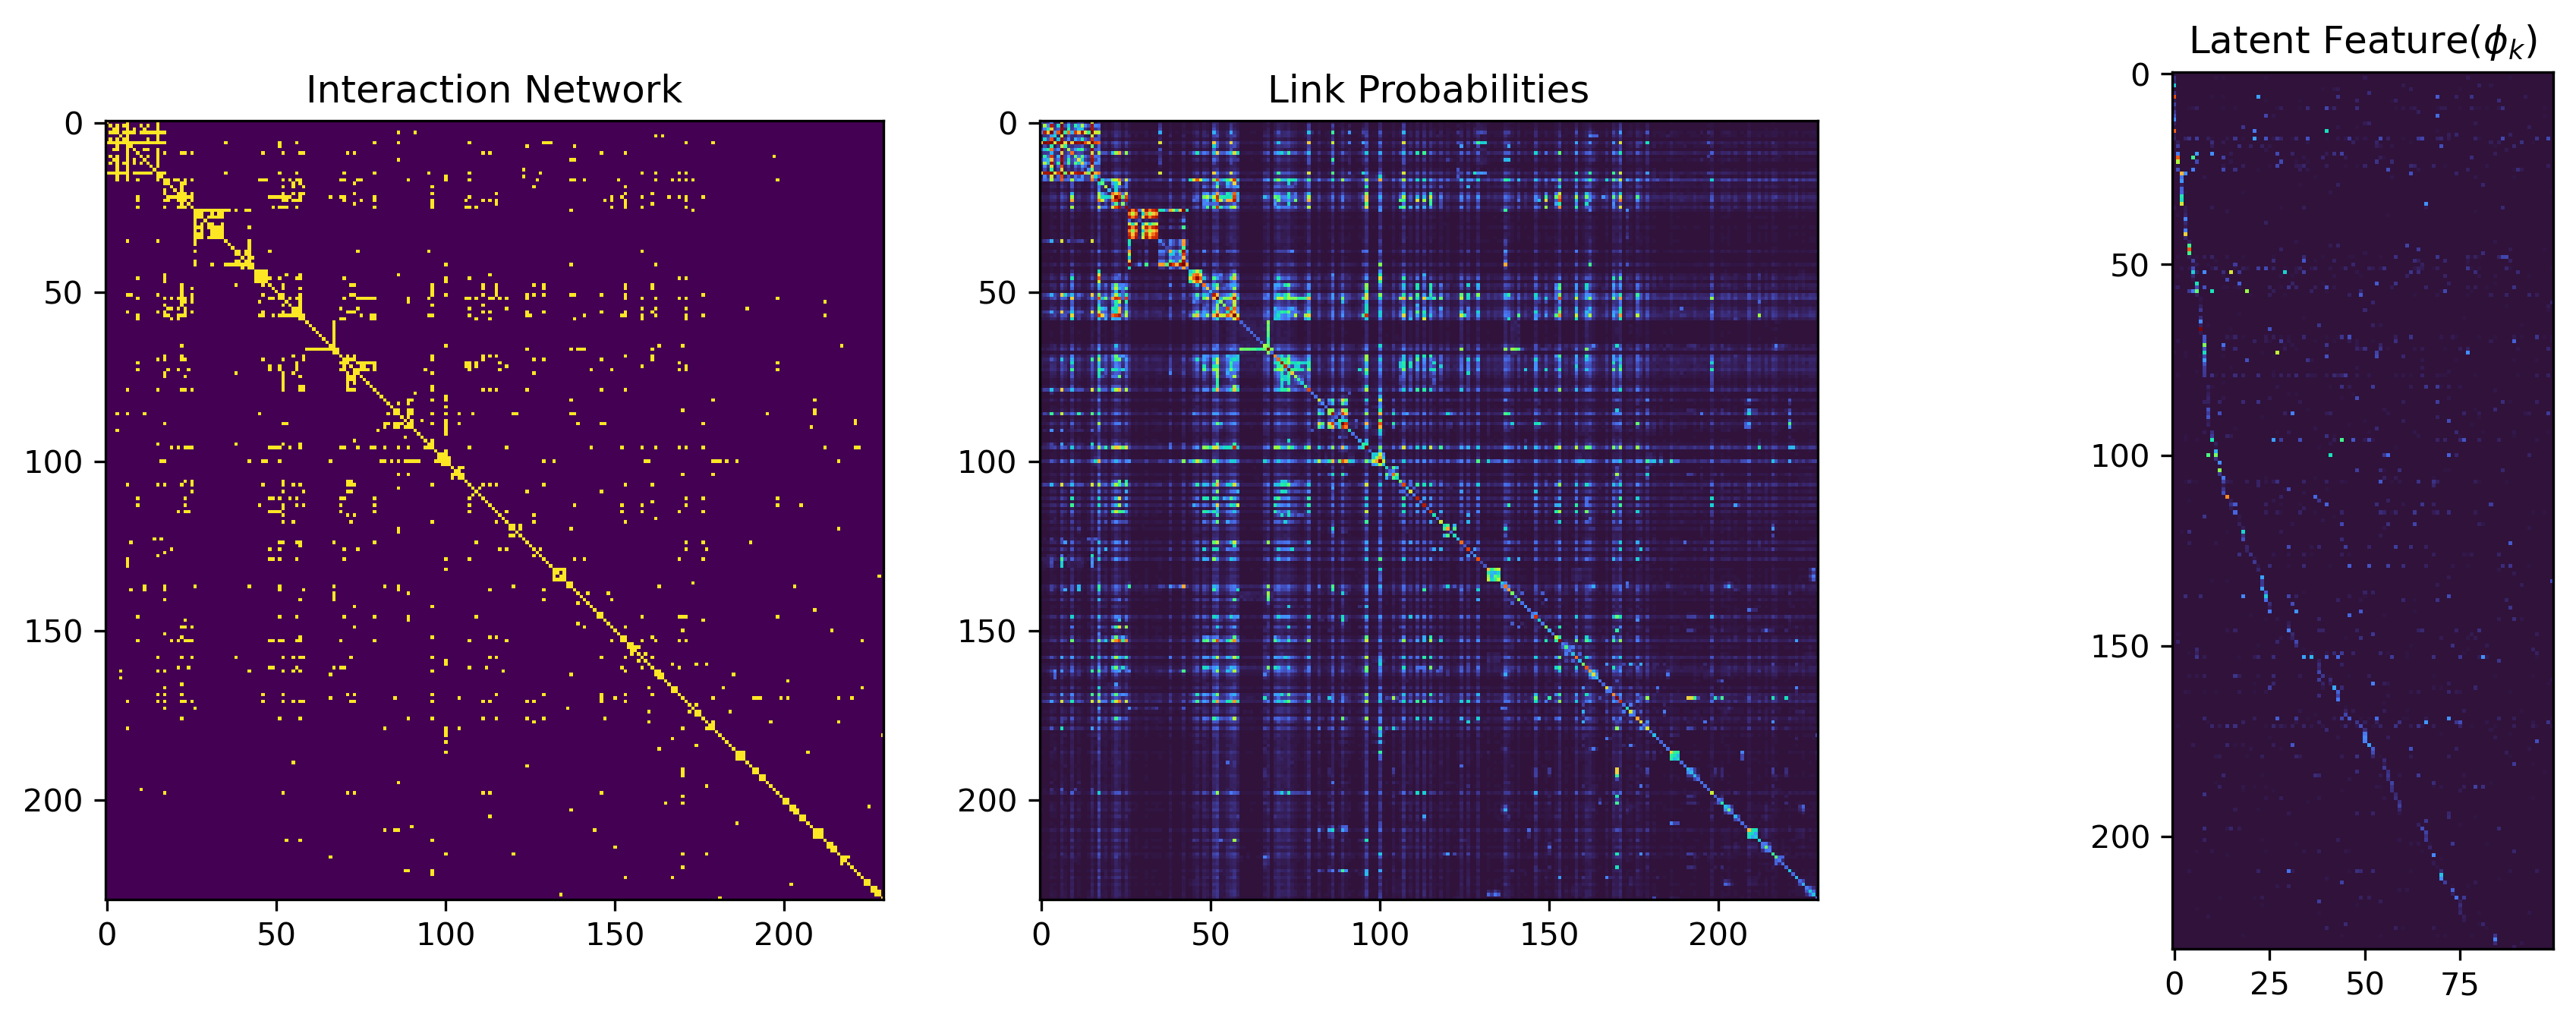

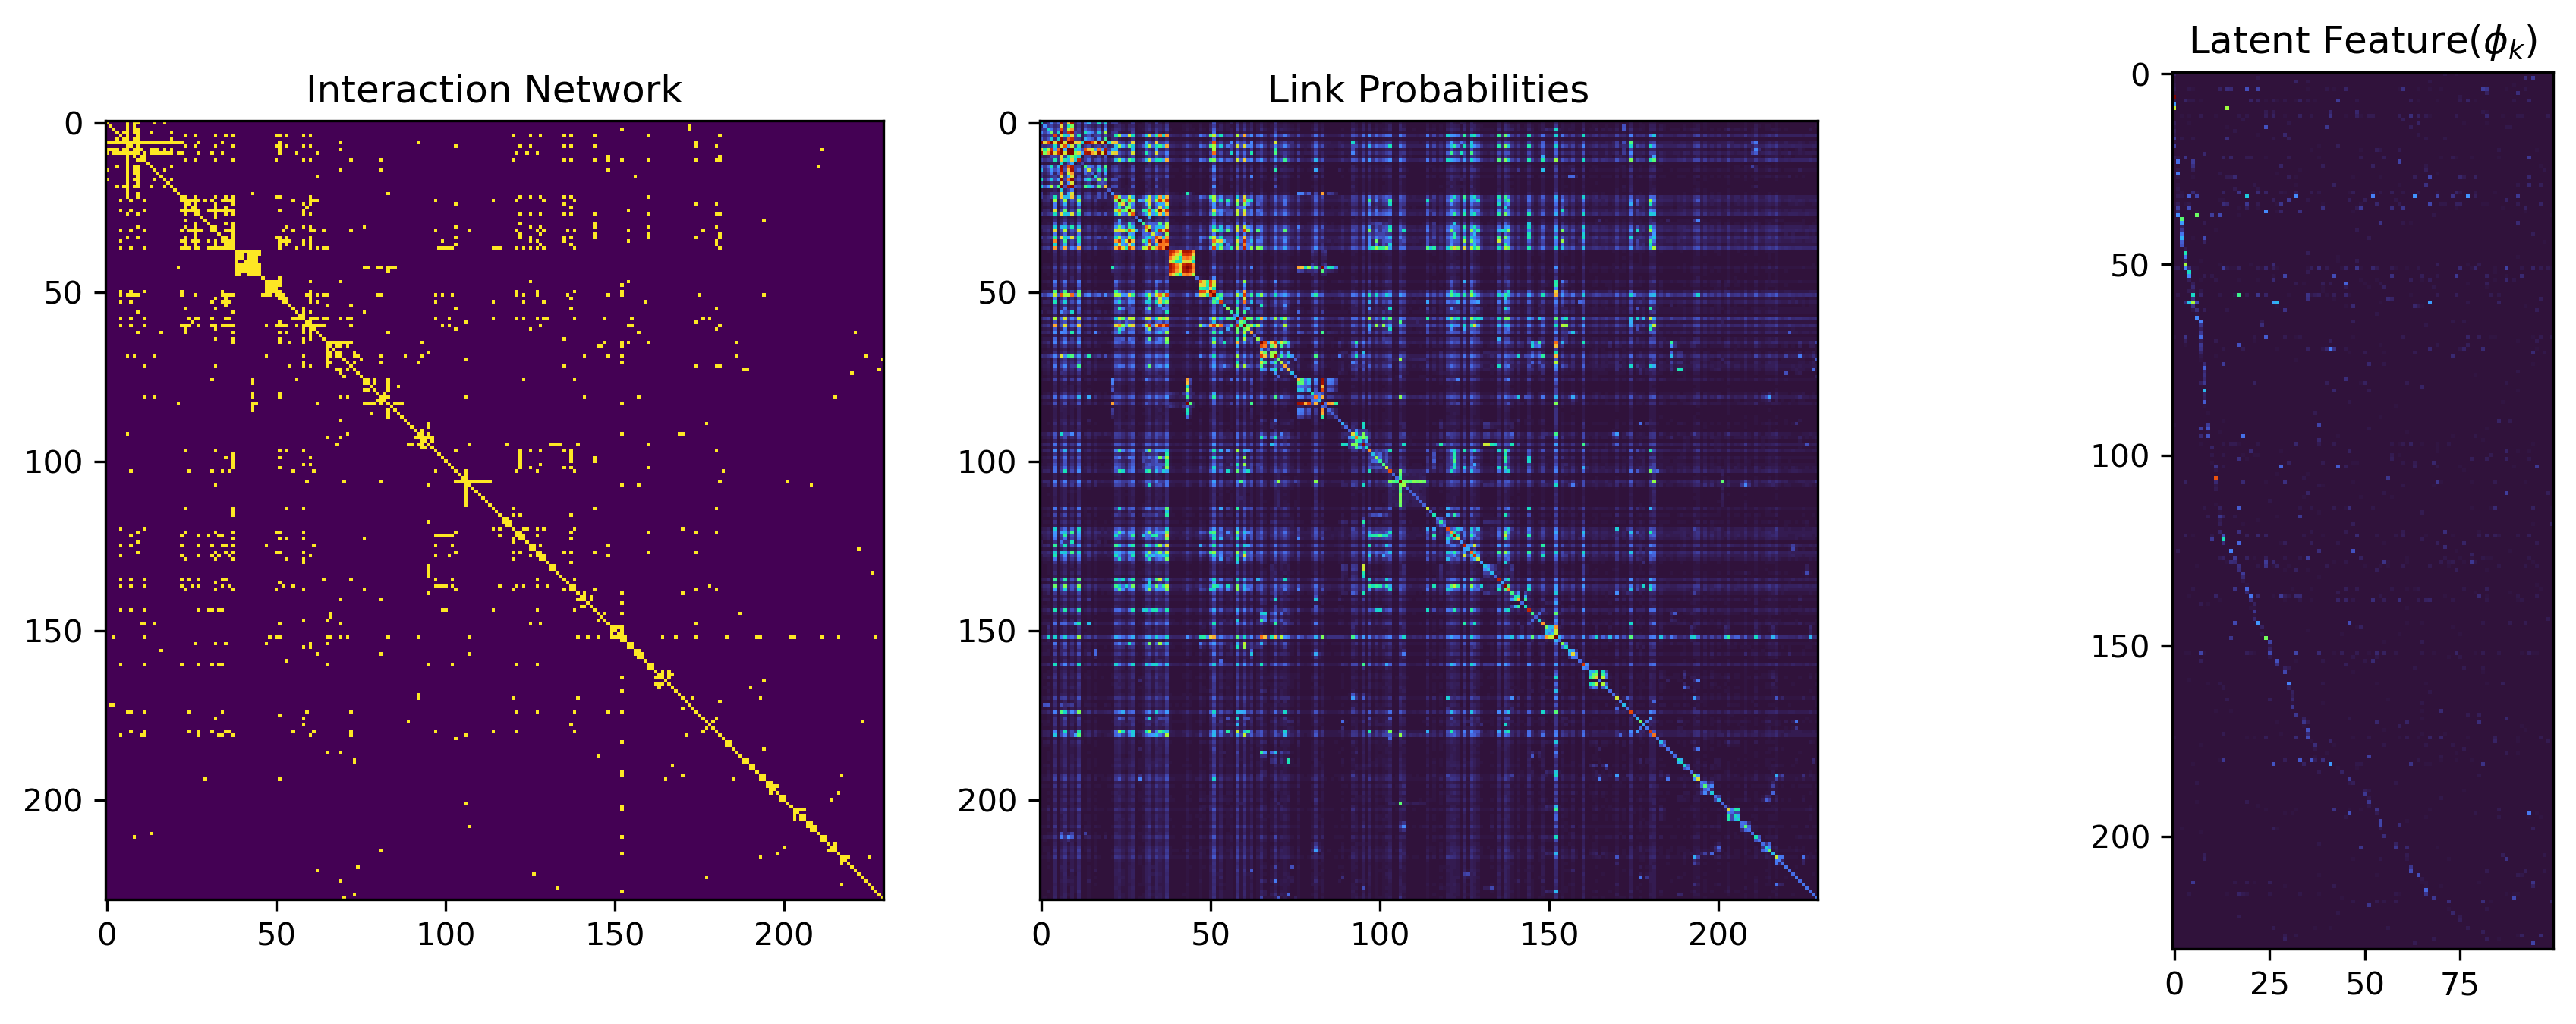

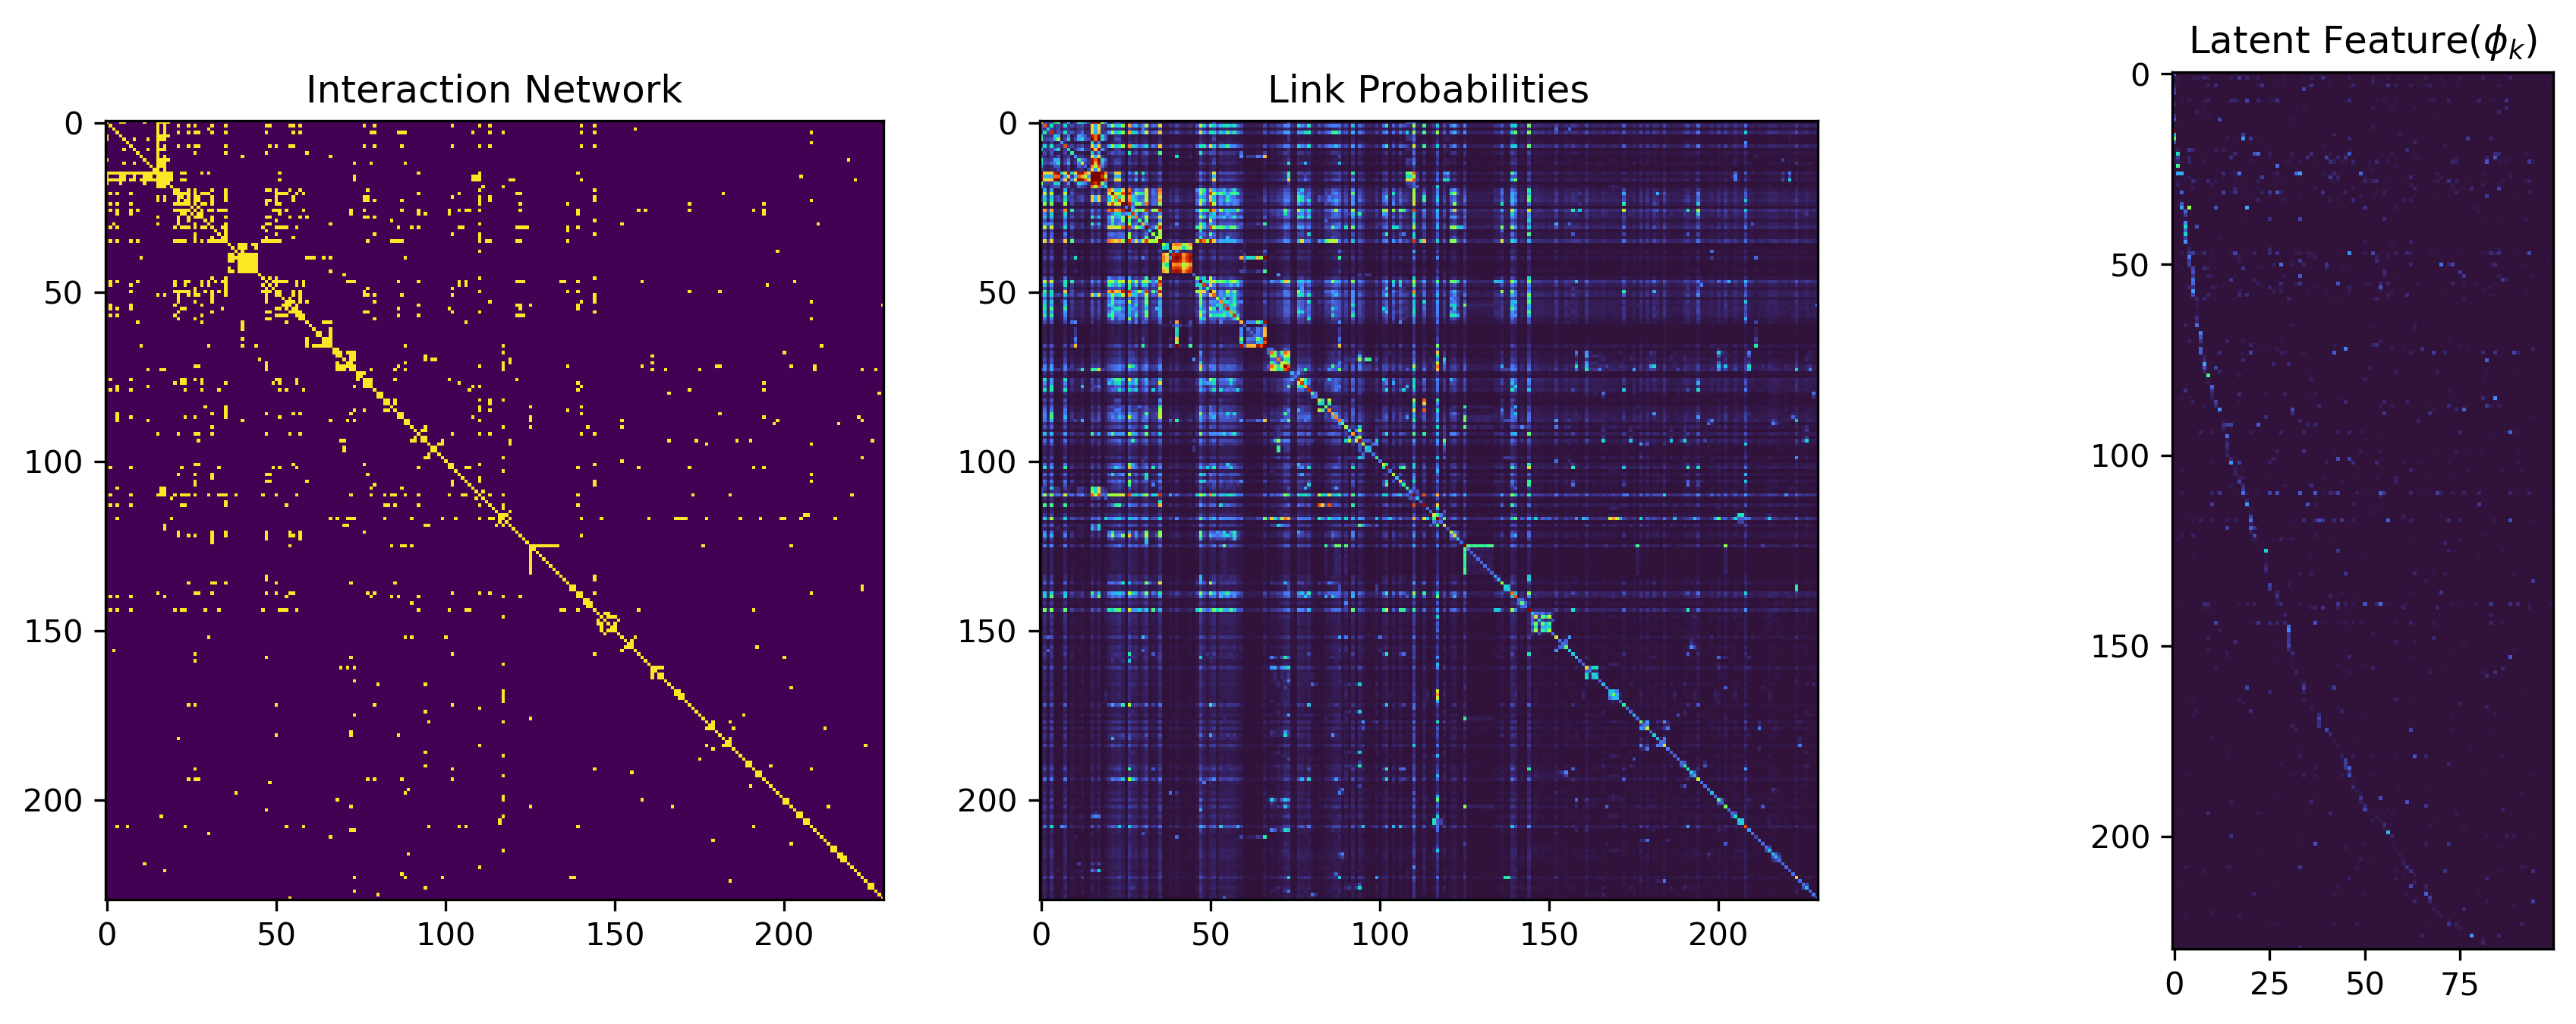

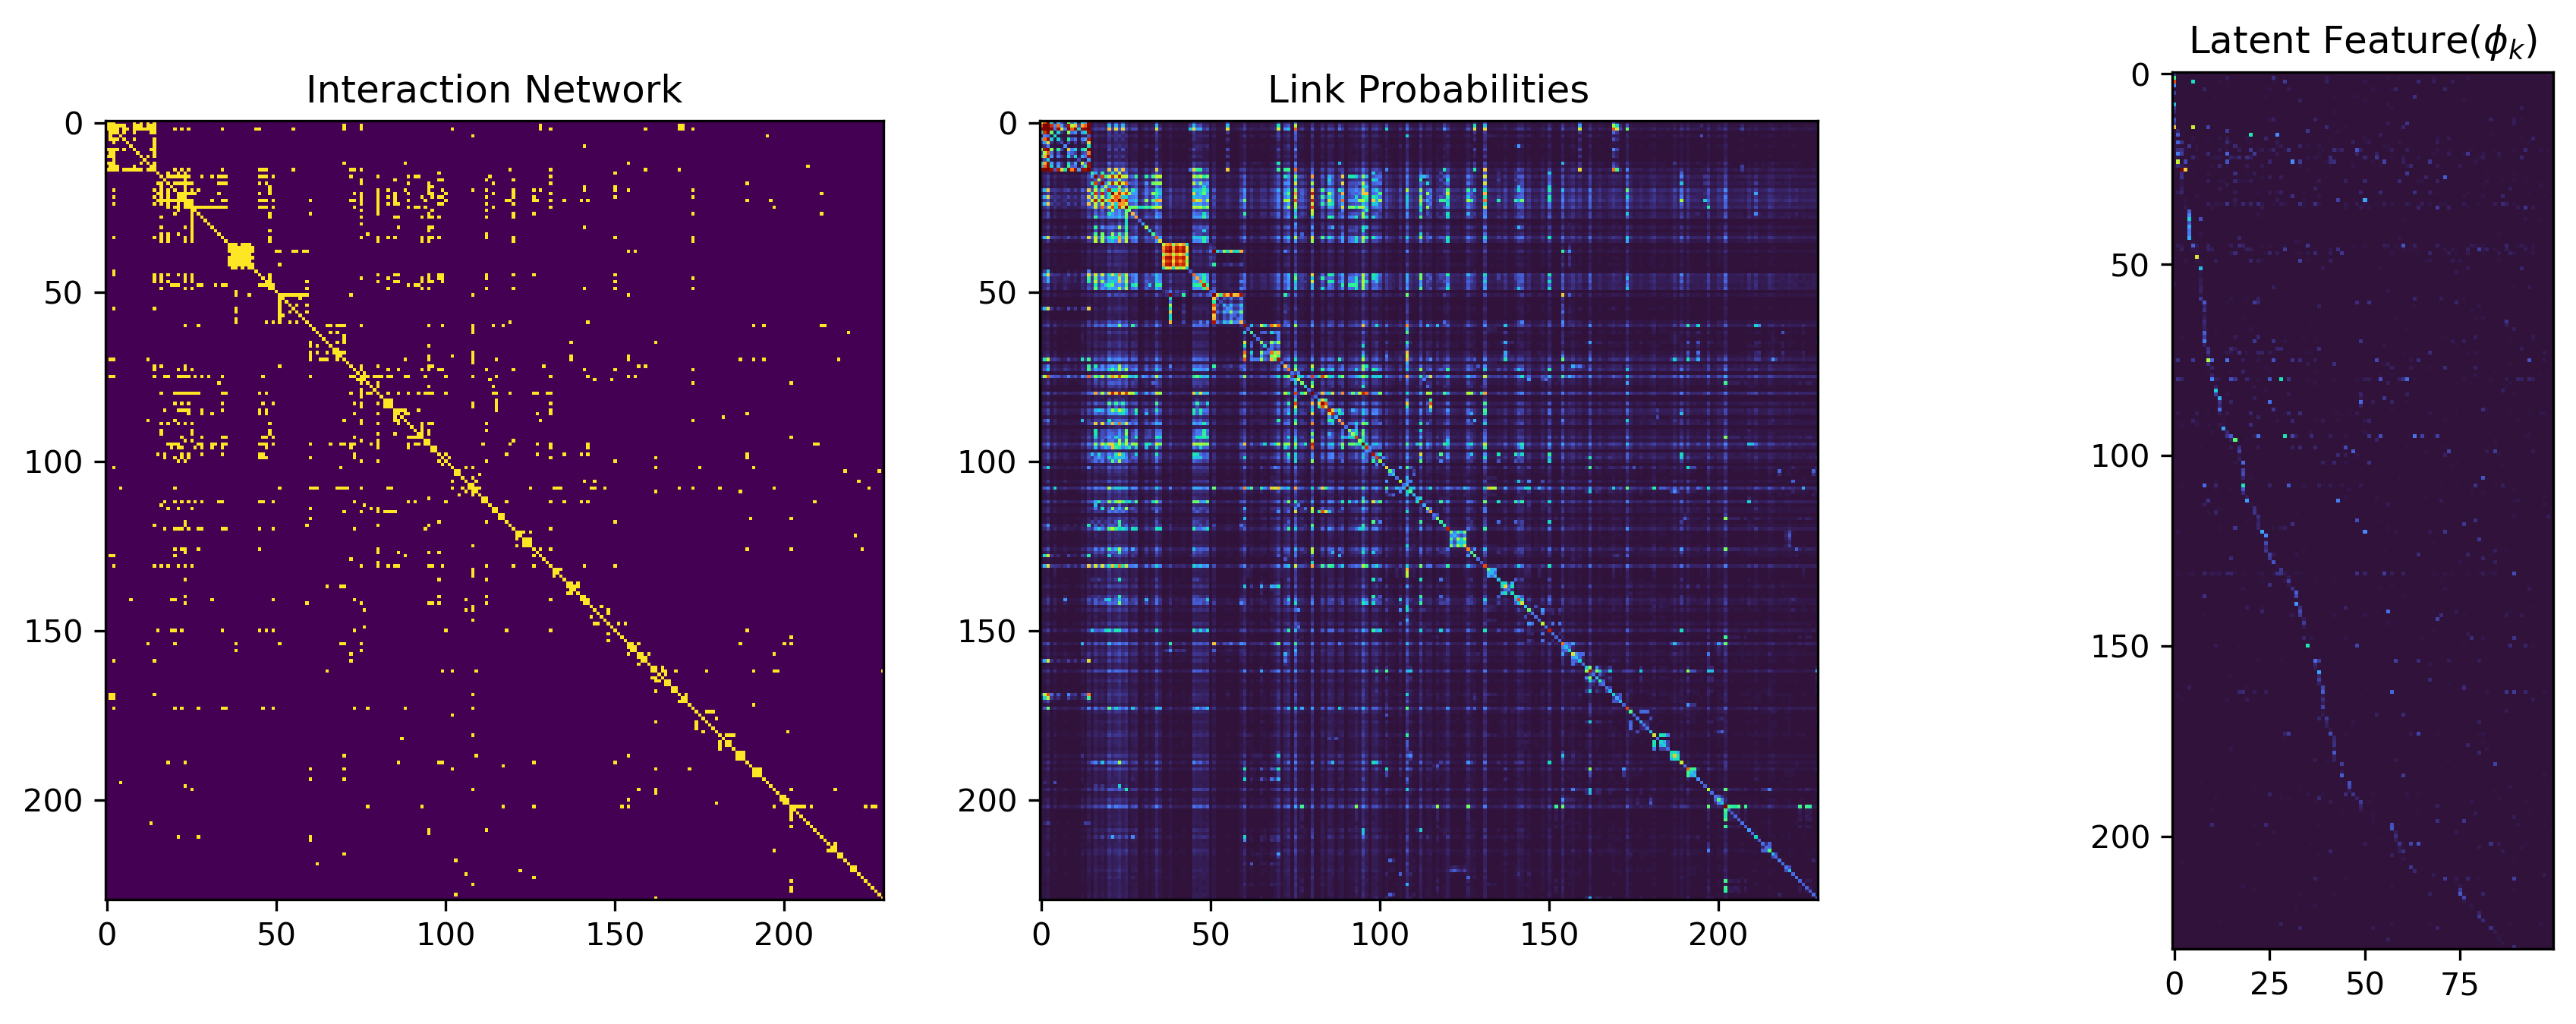

In [8]:
m_idx, n_idx = torch.nonzero(protein_data, as_tuple=True)
X = protein_data[m_idx, n_idx]
AA = protein_data + protein_data.T + torch.eye(len(protein_data))

model = HGP_EPM(protein_config)
prob_sample = torch.zeros(protein_config.N, protein_config.N)

progress = tqdm(range(protein_config.burnin + protein_config.collection))
for i in progress:
    x_ik_ddot = model.do_inference(m_idx, n_idx, X)
    
    K_positive = len(torch.sum(x_ik_ddot, dim=0).nonzero())
    
    prob = model.phi @ model.lam_kk @ model.phi.T + protein_config.eps
    prob = 1 - torch.exp(- prob)
    if i > syn_config.burnin:
        prob_sample = prob_sample + prob
        prob_ave = prob_sample / (i - syn_config.burnin)
    else:
        prob_ave = prob
        
    _, rdex = torch.sort(
        torch.sum(x_ik_ddot, dim=0),
        descending=True
    )
    _, z = torch.max(x_ik_ddot[:, rdex], dim=-1)
    _, Rank_dex = torch.sort(z)
    
    K_hardassignment = len(torch.unique(z))
    
    latent_feature = model.phi[Rank_dex][:, rdex] @ (torch.diag(model.r[rdex]) ** 0.5)
    latent_feature = torch.log(latent_feature + 9.99e-1)
    
    if (i+1)%250 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
        axs[0].set_title('Interaction Network')
        axs[0].imshow(AA[Rank_dex][:, Rank_dex])

        axs[1].set_title('Link Probabilities')
        axs[1].imshow(prob_ave[Rank_dex][:, Rank_dex], cmap='turbo')

        axs[2].set_title(r'Latent Feature($\phi_k$)')
        axs[2].imshow(latent_feature, cmap='turbo')
        
    progress.set_postfix({'K_plus': K_positive, 'K_hard': K_hardassignment, 'gamma0': model.gamma_0})